In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from ucimlrepo import fetch_ucirepo
from scipy.stats import normaltest, levene, pointbiserialr, spearmanr, chi2_contingency, ttest_ind , mannwhitneyu
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import roc_auc_score,accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from matplotlib.ticker import ScalarFormatter
from pandas.api.types import CategoricalDtype
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import resample


# Modelos 
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
from pytorch_tabnet.tab_model import TabNetClassifier

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Masking
from tensorflow.keras.optimizers import Adam
from sklearn.neural_network import MLPClassifier

### Resumen del caso de estudio

El conjunto “Default of Credit Card Clients” agrupa 30 000 registros de clientes de tarjetas en Taiwán, con variables demográficas (sexo, educación, estado civil, edad), límite de crédito, seis meses de historial de pagos y montos facturados/pagados. Este dataset proviene del UCI Machine Learning Repository (ID 350). La proporción de clases es aproximadamente 22 % de incumplimiento y 78 % de pago. Su propósito es analizar patrones que anticipen quién dejará de pagar al mes siguiente.

### Objetivo del modelo
Formular un clasificador binario que prediga la variable Y (“default next month”: 1 = incumplimiento, 0 = pago), de modo que la entidad financiera pueda ajustar políticas de crédito, provisiones y cobros de forma proactiva.

### Métrica objetivo: Recall de “incumplimiento de pago”

Maximizar el recall (TP / [TP + FN]) asegura detectar la mayor proporción posible de impagos reales. Dado que pasar por alto un incumplimiento genera pérdidas financieras directas muy superiores al coste de falsear un buen cliente, priorizar la sensibilidad es la estrategia más alineada con la gestión de riesgo crediticio.

In [54]:
# Accediendo al repositorio 

dccc = fetch_ucirepo(id=350)

# Accediendo a la información del dataset

data = dccc['data']

# Accediendo a las variables del dataset

df_dccc  = data['original']  # DataFrame con todas las variables + Y

# Mostrando las primeras filas del DataFrame

df_dccc.head(15)



,ID,X1,X2,X3,X4,X5,X6,X7,X8,X9,...,X15,X16,X17,X18,X19,X20,X21,X22,X23,Y
0,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0
5,6,50000,1,1,2,37,0,0,0,0,...,19394,19619,20024,2500,1815,657,1000,1000,800,0
6,7,500000,1,1,2,29,0,0,0,0,...,542653,483003,473944,55000,40000,38000,20239,13750,13770,0
7,8,100000,2,2,2,23,0,-1,-1,0,...,221,-159,567,380,601,0,581,1687,1542,0
8,9,140000,2,3,1,28,0,0,2,0,...,12211,11793,3719,3329,0,432,1000,1000,1000,0
9,10,20000,1,3,2,35,-2,-2,-2,-2,...,0,13007,13912,0,0,0,13007,1122,0,0


In [55]:
# Renombrar las columnas del DataFrame para que sean más legibles


# Primero, definimos un diccionario con el mapeo de nombres:
renombrar = {
    'ID':    'cliente_id',
    'X1':    'monto_credito',               # Monto del crédito otorgado
    'X2':    'genero',                      # Género: 1=hombre, 2=mujer
    'X3':    'nivel_educacion',             # Educación: 1=posgrado,2=universidad,3=secundaria,4=otros
    'X4':    'estado_civil',                # 1=casado,2=soltero,3=otros
    'X5':    'edad',                        # Edad en años
    # Historial de pagos: septiembre a abril 2005
    'X6':    'pago_sep2005',                
    'X7':    'pago_ago2005',
    'X8':    'pago_jul2005',
    'X9':    'pago_jun2005',
    'X10':   'pago_may2005',
    'X11':   'pago_abr2005',
    # Montos de factura: septiembre a abril 2005
    'X12':   'factura_sep2005',
    'X13':   'factura_ago2005',
    'X14':   'factura_jul2005',
    'X15':   'factura_jun2005',
    'X16':   'factura_may2005',
    'X17':   'factura_abr2005',
    # Montos pagados: septiembre a abril 2005
    'X18':   'pagado_sep2005',
    'X19':   'pagado_ago2005',
    'X20':   'pagado_jul2005',
    'X21':   'pagado_jun2005',
    'X22':   'pagado_may2005',
    'X23':   'pagado_abr2005',
    'Y':     'incumplimiento'               # 1 = default, 0 = pago
}

# Aplica el renombrado
df_dccc = df_dccc.rename(columns=renombrar)

# Verifica el resultado
df_dccc.head(15)


,cliente_id,monto_credito,genero,nivel_educacion,estado_civil,edad,pago_sep2005,pago_ago2005,pago_jul2005,pago_jun2005,...,factura_jun2005,factura_may2005,factura_abr2005,pagado_sep2005,pagado_ago2005,pagado_jul2005,pagado_jun2005,pagado_may2005,pagado_abr2005,incumplimiento
0,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0
5,6,50000,1,1,2,37,0,0,0,0,...,19394,19619,20024,2500,1815,657,1000,1000,800,0
6,7,500000,1,1,2,29,0,0,0,0,...,542653,483003,473944,55000,40000,38000,20239,13750,13770,0
7,8,100000,2,2,2,23,0,-1,-1,0,...,221,-159,567,380,601,0,581,1687,1542,0
8,9,140000,2,3,1,28,0,0,2,0,...,12211,11793,3719,3329,0,432,1000,1000,1000,0
9,10,20000,1,3,2,35,-2,-2,-2,-2,...,0,13007,13912,0,0,0,13007,1122,0,0


In [56]:
# Inspeccionando dimensiones del DataFrame

n_rows, n_cols = df_dccc.shape
print(f"Filas: {n_rows}, Columnas: {n_cols}")


Filas: 30000, Columnas: 25


In [57]:
# Validando el tipo de datos de cada columna

df_dccc.dtypes

cliente_id         int64
monto_credito      int64
genero             int64
nivel_educacion    int64
estado_civil       int64
edad               int64
pago_sep2005       int64
pago_ago2005       int64
pago_jul2005       int64
pago_jun2005       int64
pago_may2005       int64
pago_abr2005       int64
factura_sep2005    int64
factura_ago2005    int64
factura_jul2005    int64
factura_jun2005    int64
factura_may2005    int64
factura_abr2005    int64
pagado_sep2005     int64
pagado_ago2005     int64
pagado_jul2005     int64
pagado_jun2005     int64
pagado_may2005     int64
pagado_abr2005     int64
incumplimiento     int64
dtype: object

In [58]:
# Identificando valores nulos en el DataFrame

df_dccc.isnull().sum()



cliente_id         0
monto_credito      0
genero             0
nivel_educacion    0
estado_civil       0
edad               0
pago_sep2005       0
pago_ago2005       0
pago_jul2005       0
pago_jun2005       0
pago_may2005       0
pago_abr2005       0
factura_sep2005    0
factura_ago2005    0
factura_jul2005    0
factura_jun2005    0
factura_may2005    0
factura_abr2005    0
pagado_sep2005     0
pagado_ago2005     0
pagado_jul2005     0
pagado_jun2005     0
pagado_may2005     0
pagado_abr2005     0
incumplimiento     0
dtype: int64

In [59]:
# Identificando posibles valores duplicados en el DataFrame

df_dccc.duplicated().sum()

0

In [60]:
# Asignando nombres a las variables categóricas

# Crear copia del DataFrame original
df_limpio = df_dccc.copy(deep=True)

# Mapas para variables categóricas simples, con fillna para códigos no contemplados
map_genero = {1: 'hombre', 2: 'mujer'}
df_limpio['genero'] = df_limpio['genero'] \
    .map(map_genero) \
    .fillna('desconocido')

map_educacion = {1: 'posgrado', 2: 'universidad', 3: 'secundaria', 4: 'otros'}
df_limpio['nivel_educacion'] = df_limpio['nivel_educacion'] \
    .map(map_educacion) \
    .fillna('desconocido')

map_estado_civil = {1: 'casado', 2: 'soltero', 3: 'otros'}
df_limpio['estado_civil'] = df_limpio['estado_civil'] \
    .map(map_estado_civil) \
    .fillna('desconocido')

# Mantener la variable numérica original y crear una versión texto para reporting
map_incumplimiento = {0: 'no incumple', 1: 'incumple'}
df_limpio['incumplimiento_txt'] = df_limpio['incumplimiento'] \
    .map(map_incumplimiento)

# Mapeo del historial de pagos: conservar columnas originales y crear versiones textuales
map_historial_pago = {
    -2: 'pago adelantado',
    -1: 'pago puntual',
     0: 'pago pendiente'
}
map_historial_pago.update({i: f'retraso {i} meses' for i in range(1, 10)})

cols_hist = [
    'pago_sep2005', 'pago_ago2005', 'pago_jul2005',
    'pago_jun2005', 'pago_may2005', 'pago_abr2005'
]

for col in cols_hist:
    df_limpio[f'{col}_txt'] = df_limpio[col] \
        .map(map_historial_pago) \
        .fillna('desconocido')

# Verificación
df_limpio.head(15)


,cliente_id,monto_credito,genero,nivel_educacion,estado_civil,edad,pago_sep2005,pago_ago2005,pago_jul2005,pago_jun2005,...,pagado_may2005,pagado_abr2005,incumplimiento,incumplimiento_txt,pago_sep2005_txt,pago_ago2005_txt,pago_jul2005_txt,pago_jun2005_txt,pago_may2005_txt,pago_abr2005_txt
0,1,20000,mujer,universidad,casado,24,2,2,-1,-1,...,0,0,1,incumple,retraso 2 meses,retraso 2 meses,pago puntual,pago puntual,pago adelantado,pago adelantado
1,2,120000,mujer,universidad,soltero,26,-1,2,0,0,...,0,2000,1,incumple,pago puntual,retraso 2 meses,pago pendiente,pago pendiente,pago pendiente,retraso 2 meses
2,3,90000,mujer,universidad,soltero,34,0,0,0,0,...,1000,5000,0,no incumple,pago pendiente,pago pendiente,pago pendiente,pago pendiente,pago pendiente,pago pendiente
3,4,50000,mujer,universidad,casado,37,0,0,0,0,...,1069,1000,0,no incumple,pago pendiente,pago pendiente,pago pendiente,pago pendiente,pago pendiente,pago pendiente
4,5,50000,hombre,universidad,casado,57,-1,0,-1,0,...,689,679,0,no incumple,pago puntual,pago pendiente,pago puntual,pago pendiente,pago pendiente,pago pendiente
5,6,50000,hombre,posgrado,soltero,37,0,0,0,0,...,1000,800,0,no incumple,pago pendiente,pago pendiente,pago pendiente,pago pendiente,pago pendiente,pago pendiente
6,7,500000,hombre,posgrado,soltero,29,0,0,0,0,...,13750,13770,0,no incumple,pago pendiente,pago pendiente,pago pendiente,pago pendiente,pago pendiente,pago pendiente
7,8,100000,mujer,universidad,soltero,23,0,-1,-1,0,...,1687,1542,0,no incumple,pago pendiente,pago puntual,pago puntual,pago pendiente,pago pendiente,pago puntual
8,9,140000,mujer,secundaria,casado,28,0,0,2,0,...,1000,1000,0,no incumple,pago pendiente,pago pendiente,retraso 2 meses,pago pendiente,pago pendiente,pago pendiente
9,10,20000,hombre,secundaria,soltero,35,-2,-2,-2,-2,...,1122,0,0,no incumple,pago adelantado,pago adelantado,pago adelantado,pago adelantado,pago puntual,pago puntual


In [61]:
# Tipos de datos de cada columna

print("\n>>> TIPOS DE DATOS:")
print(df_limpio.dtypes)



>>> TIPOS DE DATOS:
cliente_id             int64
monto_credito          int64
genero                object
nivel_educacion       object
estado_civil          object
edad                   int64
pago_sep2005           int64
pago_ago2005           int64
pago_jul2005           int64
pago_jun2005           int64
pago_may2005           int64
pago_abr2005           int64
factura_sep2005        int64
factura_ago2005        int64
factura_jul2005        int64
factura_jun2005        int64
factura_may2005        int64
factura_abr2005        int64
pagado_sep2005         int64
pagado_ago2005         int64
pagado_jul2005         int64
pagado_jun2005         int64
pagado_may2005         int64
pagado_abr2005         int64
incumplimiento         int64
incumplimiento_txt    object
pago_sep2005_txt      object
pago_ago2005_txt      object
pago_jul2005_txt      object
pago_jun2005_txt      object
pago_may2005_txt      object
pago_abr2005_txt      object
dtype: object


In [62]:
# Estadísticas descriptivas de variables numéricas

# Seleccionando solo numéricas de entrada, excluyendo ID y target
num_cols = (
    df_limpio
    .select_dtypes(include='number')
    .columns
    .drop(['cliente_id', 'incumplimiento'])
)
num_df = df_limpio[num_cols]

# Estadísticos básicos y shape
desc = num_df.describe(percentiles=[0.01, 0.25, 0.5, 0.75, 0.99]).T

# Sesgo y curtosis
desc['skewness'] = num_df.skew()
desc['kurtosis'] = num_df.kurtosis()

# Presentación: transponer para que cada estadístico sea fila
stats = desc.T

print("\n>>> ESTADÍSTICAS DESCRIPTIVAS (numéricas) + Skewness, Kurtosis & Outlier Percentiles:")
display(stats)



>>> ESTADÍSTICAS DESCRIPTIVAS (numéricas) + Skewness, Kurtosis & Outlier Percentiles:


,monto_credito,edad,pago_sep2005,pago_ago2005,pago_jul2005,pago_jun2005,pago_may2005,pago_abr2005,factura_sep2005,factura_ago2005,factura_jul2005,factura_jun2005,factura_may2005,factura_abr2005,pagado_sep2005,pagado_ago2005,pagado_jul2005,pagado_jun2005,pagado_may2005,pagado_abr2005
count,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.000000,30000.000000,30000.000000,30000.000000
mean,167484.322667,35.485500,-0.016700,-0.133767,-0.166200,-0.220667,-0.266200,-0.291100,51223.330900,49179.075167,4.701315e+04,43262.948967,40311.400967,38871.760400,5663.580500,5.921163e+03,5225.681500,4826.076867,4799.387633,5215.502567
std,129747.661567,9.217904,1.123802,1.197186,1.196868,1.169139,1.133187,1.149988,73635.860576,71173.768783,6.934939e+04,64332.856134,60797.155770,59554.107537,16563.280354,2.304087e+04,17606.961470,15666.159744,15278.305679,17777.465775
min,10000.000000,21.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-165580.000000,-69777.000000,-1.572640e+05,-170000.000000,-81334.000000,-339603.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000
1%,10000.000000,22.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-81.000000,-200.000000,-2.000000e+02,-212.020000,-232.010000,-331.030000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000
25%,50000.000000,28.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,3558.750000,2984.750000,2.666250e+03,2326.750000,1763.000000,1256.000000,1000.000000,8.330000e+02,390.000000,296.000000,252.500000,117.750000
50%,140000.000000,34.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,22381.500000,21200.000000,2.008850e+04,19052.000000,18104.500000,17071.000000,2100.000000,2.009000e+03,1800.000000,1500.000000,1500.000000,1500.000000
75%,240000.000000,41.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,67091.000000,64006.250000,6.016475e+04,54506.000000,50190.500000,49198.250000,5006.000000,5.000000e+03,4505.000000,4013.250000,4031.500000,4000.000000
99%,500000.000000,60.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,350110.680000,337495.280000,3.250304e+05,304997.270000,285868.330000,279505.060000,66522.180000,7.665102e+04,70000.000000,67054.440000,65607.560000,82619.050000
max,1000000.000000,79.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,964511.000000,983931.000000,1.664089e+06,891586.000000,927171.000000,961664.000000,873552.000000,1.684259e+06,896040.000000,621000.000000,426529.000000,528666.000000


In [63]:
# Estadísticas descriptivas de variables categóricas

cat_cols = [
    'genero',
    'nivel_educacion',
    'estado_civil',
    'incumplimiento_txt',
    'pago_sep2005_txt',
    'pago_ago2005_txt',
    'pago_jul2005_txt',
    'pago_jun2005_txt',
    'pago_may2005_txt',
    'pago_abr2005_txt'
]

df_cat = df_limpio[cat_cols]

# Describe básico
desc_cat = df_cat.describe().T

# Añadir conteo y porcentaje de nulos
n_nulos = df_cat.isnull().sum()
p_nulos = (n_nulos / len(df_cat) * 100).round(2)
desc_cat['nulos']   = n_nulos
desc_cat['% nulos'] = p_nulos

print("\n>>> RESUMEN DE CATEGÓRICAS (incluye historiales de pago):")
display(desc_cat)




>>> RESUMEN DE CATEGÓRICAS (incluye historiales de pago):


,count,unique,top,freq,nulos,% nulos
genero,30000,2,mujer,18112,0,0.0
nivel_educacion,30000,5,universidad,14030,0,0.0
estado_civil,30000,4,soltero,15964,0,0.0
incumplimiento_txt,30000,2,no incumple,23364,0,0.0
pago_sep2005_txt,30000,11,pago pendiente,14737,0,0.0
pago_ago2005_txt,30000,11,pago pendiente,15730,0,0.0
pago_jul2005_txt,30000,11,pago pendiente,15764,0,0.0
pago_jun2005_txt,30000,11,pago pendiente,16455,0,0.0
pago_may2005_txt,30000,10,pago pendiente,16947,0,0.0
pago_abr2005_txt,30000,10,pago pendiente,16286,0,0.0


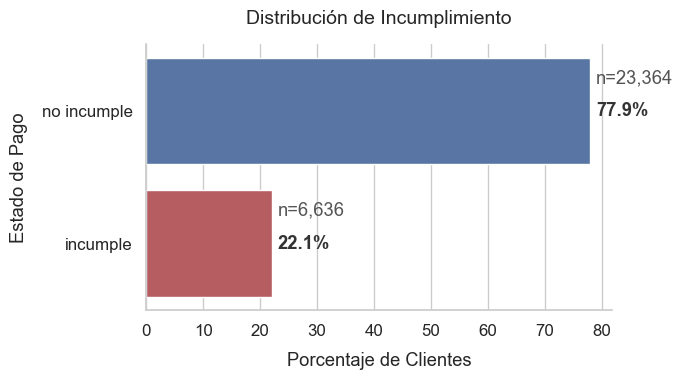

In [64]:
# Distribución de la variable objetivo con porcentajes


# Configurar estilo general
sns.set_theme(style="whitegrid", palette="muted", font_scale=1.1)
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top']   = False

# Preparar datos de conteo y porcentaje
counts = (
    df_limpio['incumplimiento_txt']
    .value_counts()
    .reindex(['no incumple', 'incumple'])
)
perc = (counts / counts.sum() * 100).round(1)

# Crear DataFrame para seaborn
df_plot = perc.reset_index()
df_plot.columns = ['estado', 'percentage']

# Gráfico de barras horizontal con hue
fig, ax = plt.subplots(figsize=(7, 4))
sns.barplot(
    data=df_plot,
    x='percentage',
    y='estado',
    hue='estado',
    palette=['#4C72B0', '#C44E52'],
    dodge=False,
    ax=ax
)

# Eliminar leyenda sólo si existe
legend = ax.get_legend()
if legend is not None:
    legend.remove()

# Anotar porcentajes y totales
for i, (p, c) in enumerate(zip(df_plot['percentage'], counts.values)):
    ax.text(
        p + 1, i,
        f"{p:.1f}%",
        va='center',
        color='#333333',
        fontweight='bold'
    )
    ax.text(
        p + 1, i - 0.25,
        f"n={c:,}",
        va='center',
        color='#555555'
    )

# Títulos y etiquetas
ax.set_title("Distribución de Incumplimiento", pad=15, fontsize=14)
ax.set_xlabel("Porcentaje de Clientes", labelpad=10)
ax.set_ylabel("Estado de Pago", labelpad=10)

plt.tight_layout()
plt.show()


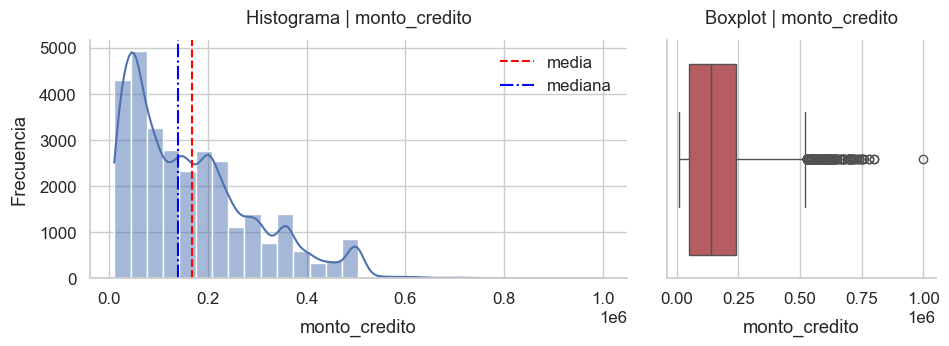

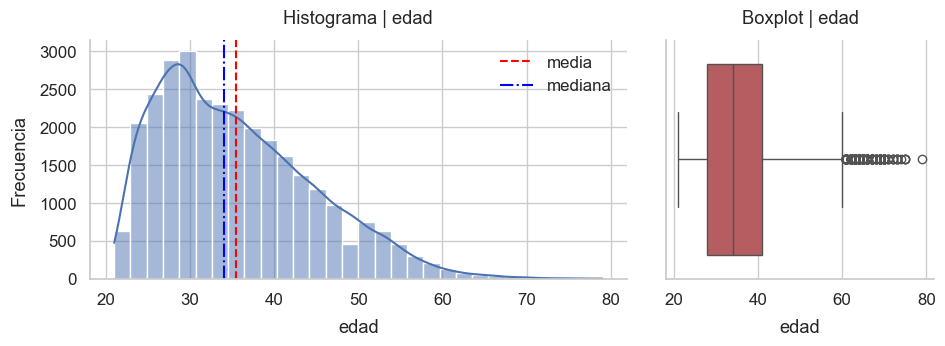

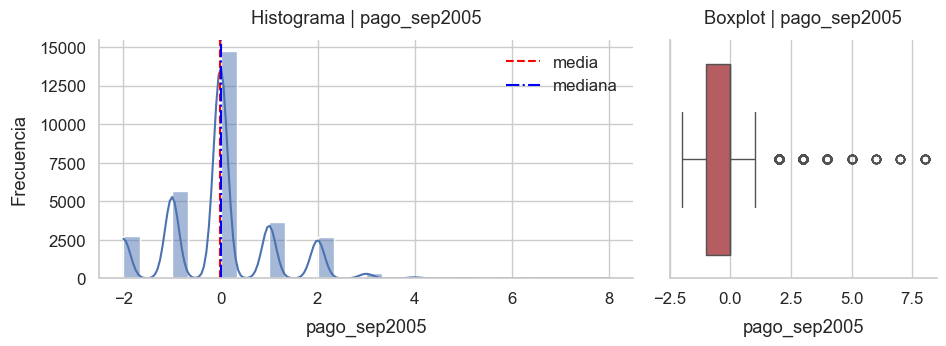

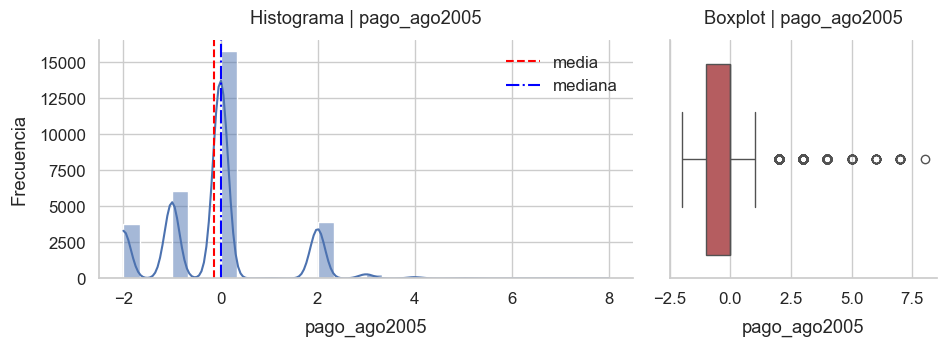

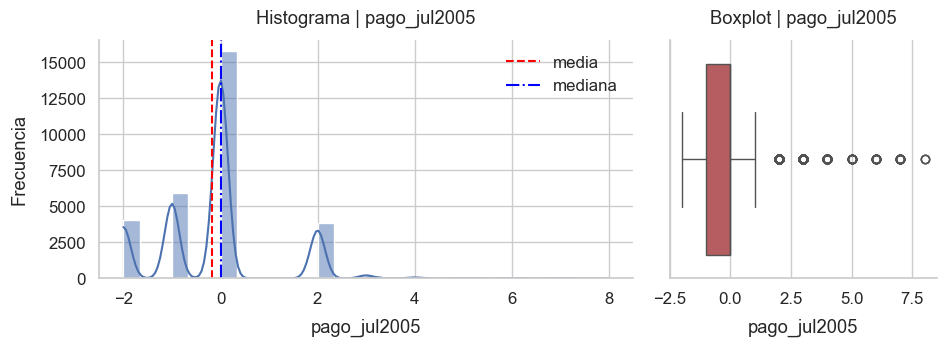

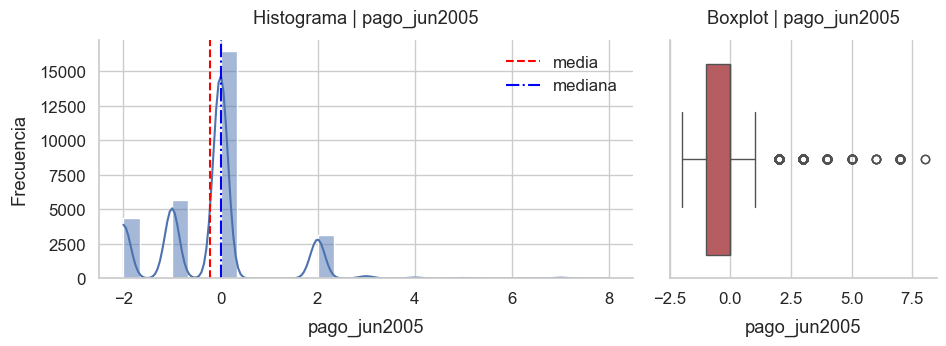

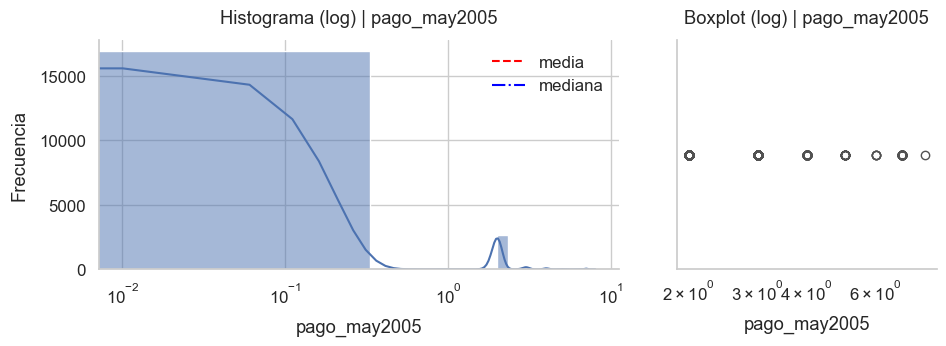

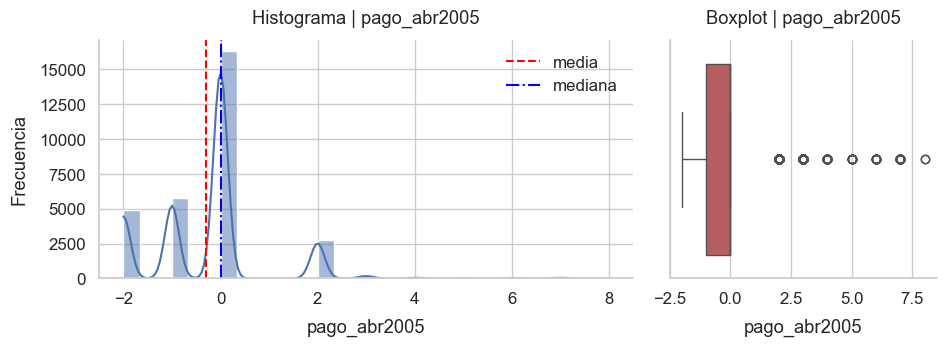

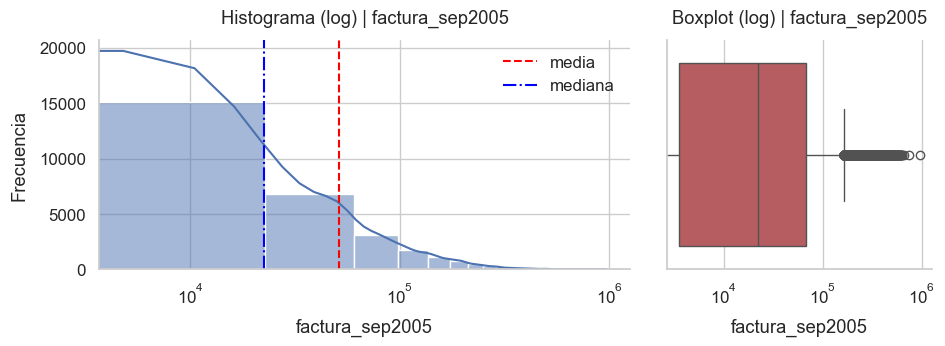

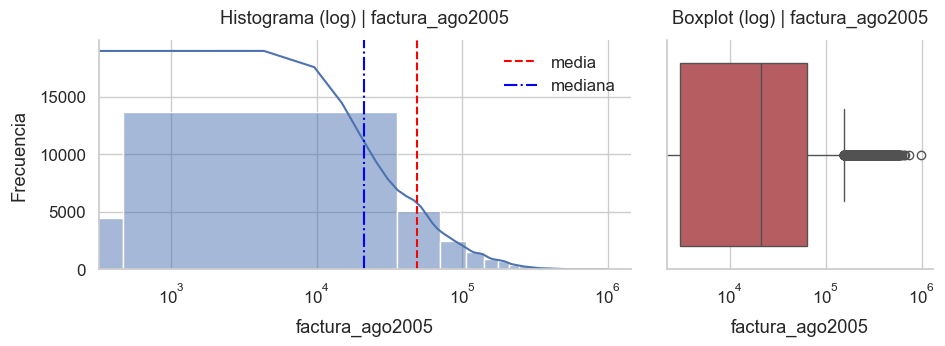

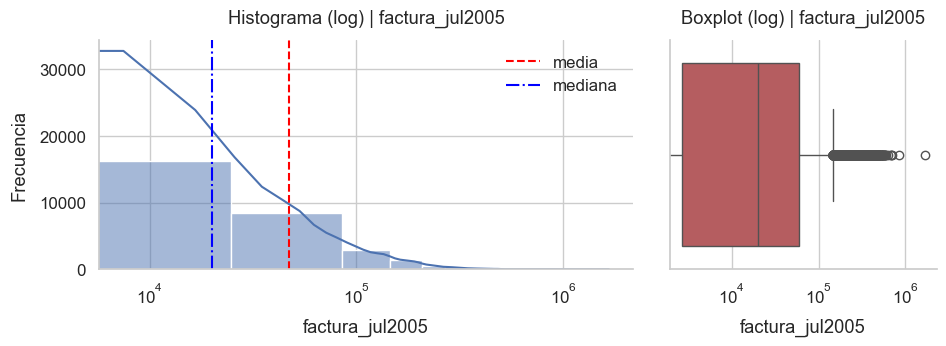

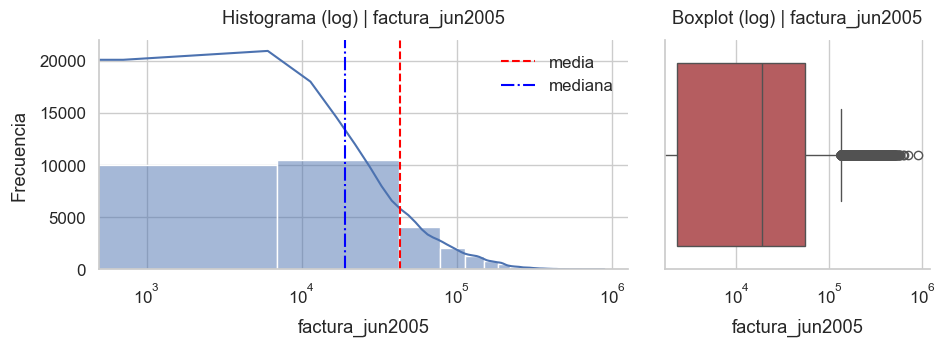

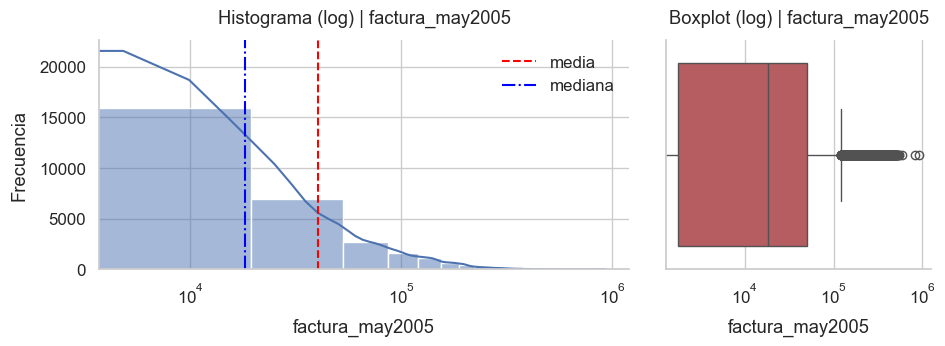

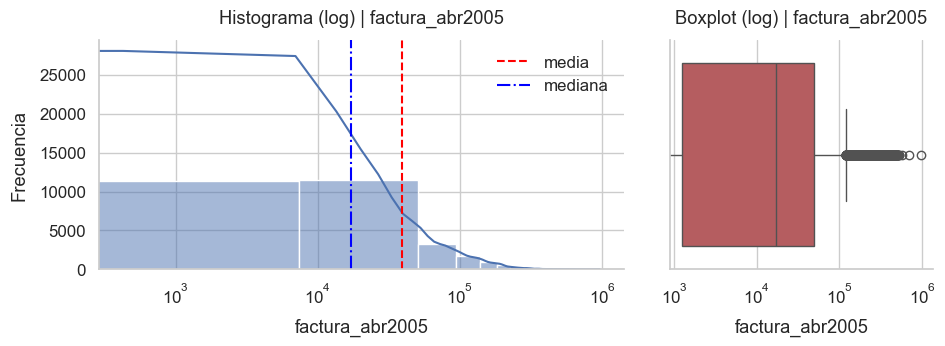

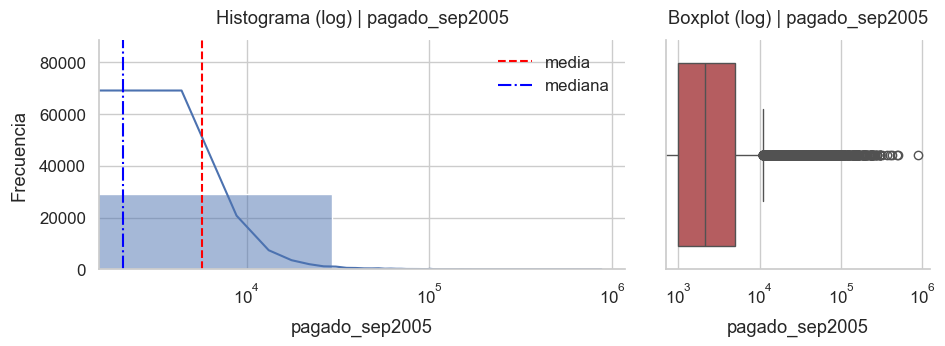

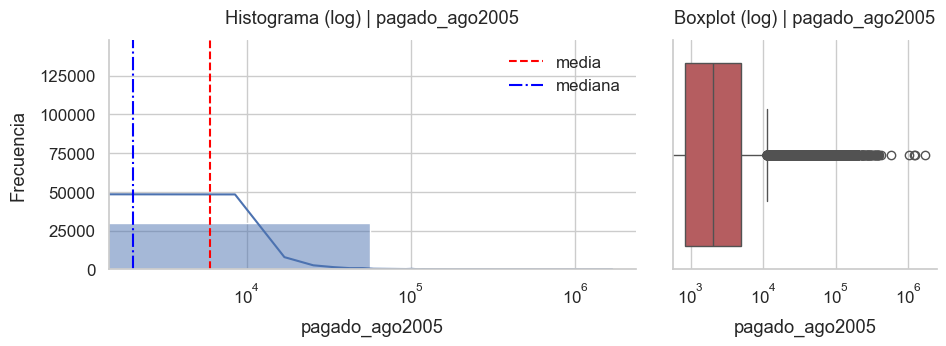

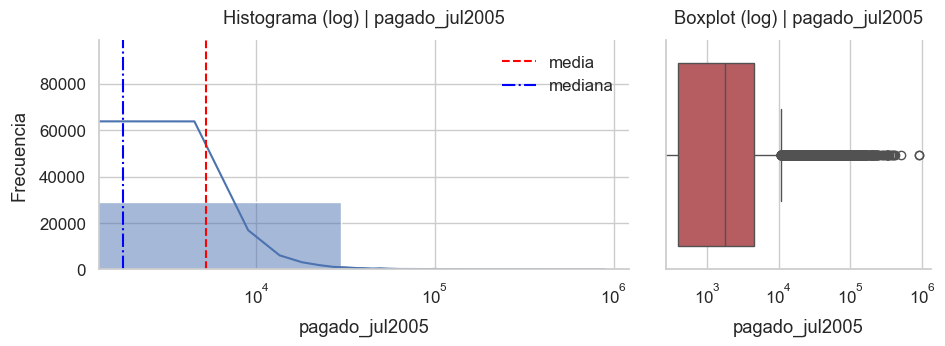

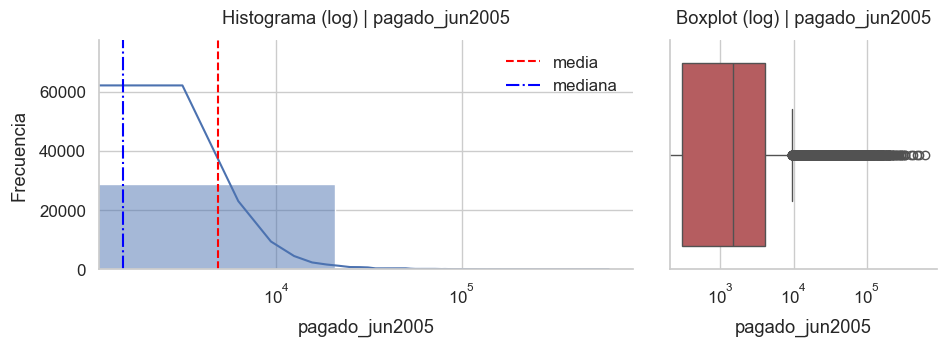

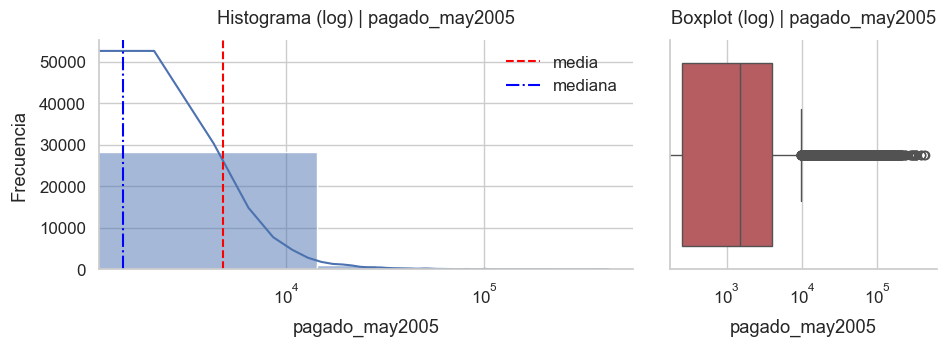

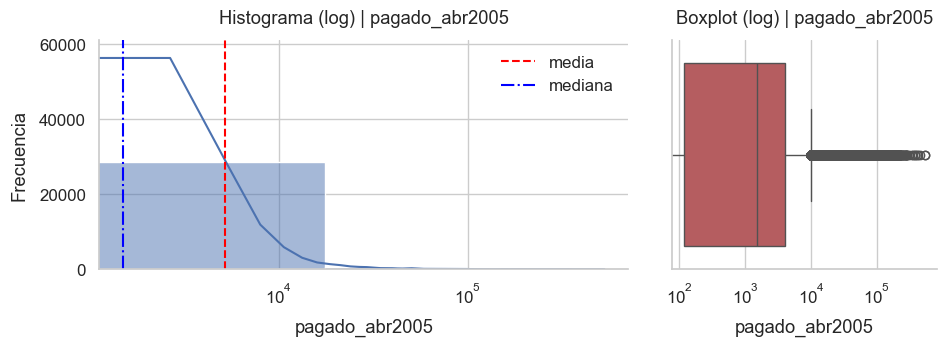

In [65]:
# Análisis univariado de variables numéricas

# Estilo general
sns.set_theme(style="whitegrid", palette="muted", font_scale=1.1)
plt.rcParams['axes.spines.top']   = False
plt.rcParams['axes.spines.right'] = False

# Separar target y features
y = df_limpio['incumplimiento']
X = df_limpio.drop(columns=['incumplimiento','cliente_id'])

# Seleccionar variables numéricas
num_vars = X.select_dtypes(include='number').columns

# Loop con criterios de visualización
for col in num_vars:
    series = X[col]
    skewness = series.skew()
    use_log = abs(skewness) > 1  # aplicar log si skew > 1

    fig, axes = plt.subplots(1, 2, figsize=(10, 4), gridspec_kw={'width_ratios': [2, 1]})
    
    # Histograma + KDE
    ax0 = axes[0]
    sns.histplot(series, bins=30, kde=True, ax=ax0, color='#4C72B0', edgecolor='white')
    ax0.set_title(f'Histograma | {col}', pad=12)
    ax0.set_xlabel(col, labelpad=8)
    ax0.set_ylabel('Frecuencia', labelpad=8)
    # Líneas de media y mediana
    ax0.axvline(series.mean(), color='red', linestyle='--', linewidth=1.5, label='media')
    ax0.axvline(series.median(), color='blue', linestyle='-.', linewidth=1.5, label='mediana')
    ax0.legend(frameon=False, loc='upper right')
    # Escala log si está muy sesgado
    if use_log:
        ax0.set_xscale('log')
        ax0.set_title(f'Histograma (log) | {col}', pad=12)
    
    # Boxplot horizontal
    ax1 = axes[1]
    sns.boxplot(x=series, ax=ax1, color='#C44E52')
    ax1.set_title(f'Boxplot | {col}', pad=12)
    ax1.set_xlabel(col, labelpad=8)
    if use_log:
        ax1.set_xscale('log')
        ax1.set_title(f'Boxplot (log) | {col}', pad=12)

    plt.tight_layout(pad=2)
    plt.show()


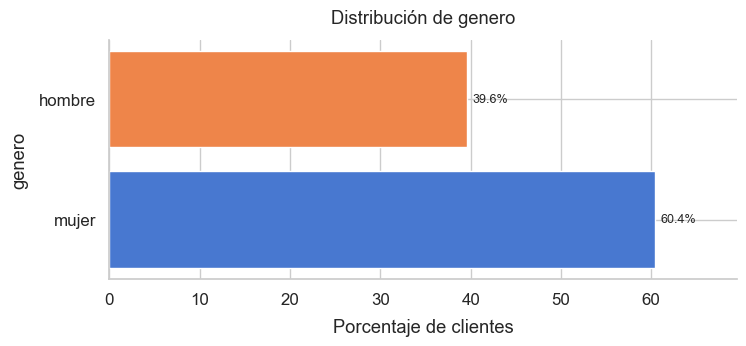

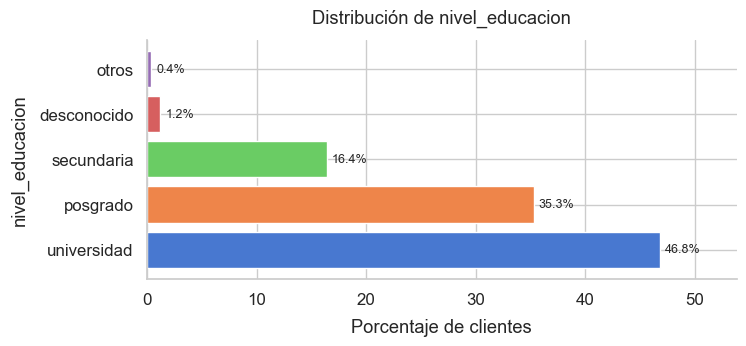

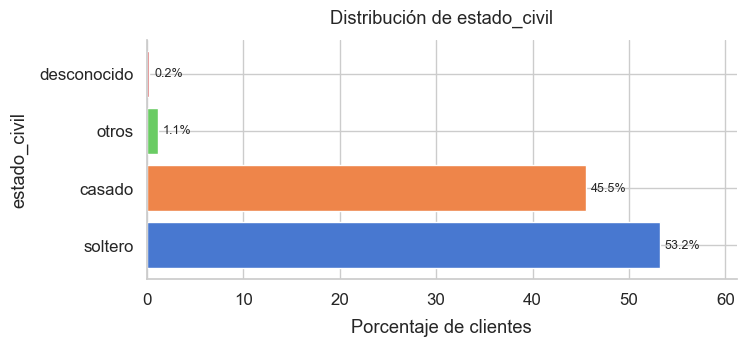

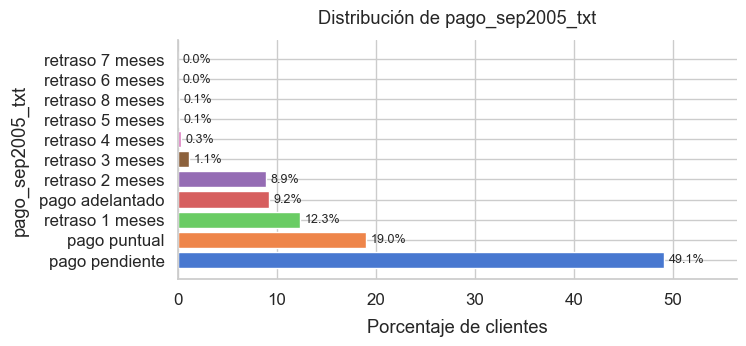

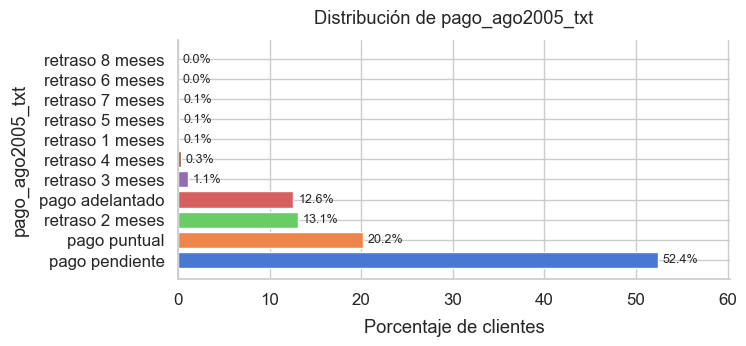

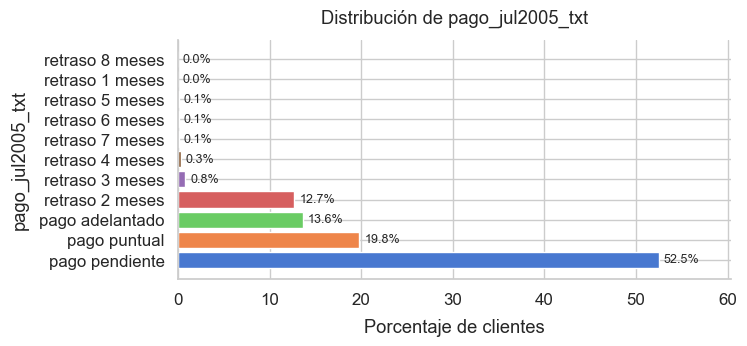

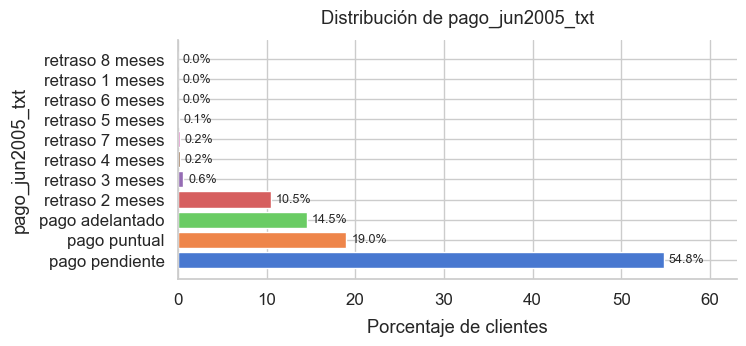

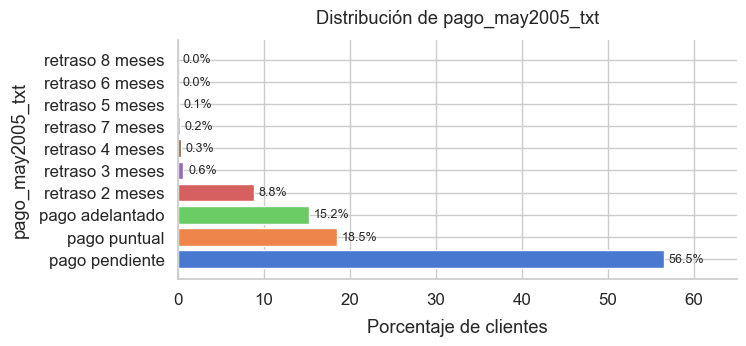

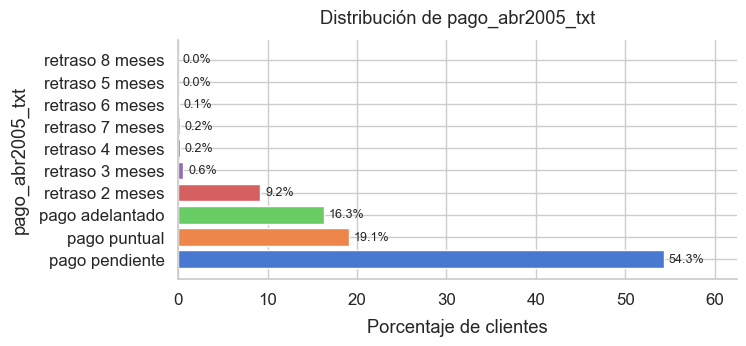

In [66]:
# Análisis univariado categórico

# Estilo limpio y uniforme
sns.set_theme(style="whitegrid", palette="muted", font_scale=1.1)
plt.rcParams['axes.spines.top']   = False
plt.rcParams['axes.spines.right'] = False

# Seleccionando variables categóricas, excluyendo el target textual
cat_vars = [
    col for col in df_limpio.select_dtypes(include='object').columns
    if col != 'incumplimiento_txt'
]

# Loop de visualización univariada
for col in cat_vars:
    counts = df_limpio[col].value_counts(dropna=False)    # conteos absolutos
    pct    = (counts / counts.sum() * 100).round(1)       # convertir a porcentaje

    # Colores: uno por categoría, extraídos de la paleta 'muted'
    colors = sns.color_palette("muted", len(pct))      # lista de colores

    # Graficando barras horizontales
    fig, ax = plt.subplots(figsize=(8, 4))
    ax.barh(pct.index, pct.values, color=colors)

    # Anotar cada barra con su porcentaje
    for i, v in enumerate(pct.values):
        ax.text(
            v + pct.max() * 0.01, i, f"{v:.1f}%",     # ligero offset hacia la derecha
            va='center', fontsize=9
        )

    # Etiquetas y estética
    ax.set_title(f"Distribución de {col}", pad=12)
    ax.set_xlabel("Porcentaje de clientes", labelpad=8)
    ax.set_ylabel(col, labelpad=8)
    ax.set_xlim(0, pct.max() * 1.15)

    plt.tight_layout(pad=2)
    plt.show()


In [67]:
# Validando cardinalidad y detección de niveles raros en variables categóricas


def reportar_cardinalidad_y_rareza(
    df: pd.DataFrame,
    cat_cols: list,
    target_col: str,
    umbral_rareza: float = 0.01
) -> pd.DataFrame:
    """
    Para cada variable categórica en cat_cols:
      - Calcula total de niveles (incluyendo NaN).
      - Detecta niveles con frecuencia < umbral_rareza.
      - Devuelve un DataFrame con 'variable', 'cardinalidad' y lista de 'niveles_raros'.
    """
    resultados = []

    for col in cat_cols:
        # Frecuencias absolutas y relativas (incluyendo NaN)
        freq_abs = df[col].value_counts(dropna=False)
        freq_rel = df[col].value_counts(normalize=True, dropna=False)
        
        # Cardinalidad (se cuenta NaN como nivel si está presente)
        card = freq_abs.shape[0]

        # Niveles raros (incluye NaN si freq < umbral)
        raros = freq_rel[freq_rel < umbral_rareza].index.tolist()
        
        resultados.append({
            'variable'       : col,
            'cardinalidad'   : card,
            'niveles_raros'  : raros or ['Ninguno']
        })

    return pd.DataFrame(resultados)

# Aplicando la función de rareza a las variables categóricas

# Identificar columnas categóricas
cat_vars = [
    c for c in df_limpio.select_dtypes(include='object').columns
    if c != 'incumplimiento_txt'
]

# Generar el reporte
df_rareza = reportar_cardinalidad_y_rareza(
    df       = df_limpio,
    cat_cols = cat_vars,
    target_col = 'incumplimiento_txt',
    umbral_rareza = 0.01
)

# Mostrarlo ordenado por mayor cardinalidad
print(df_rareza.sort_values('cardinalidad', ascending=False).to_string(index=False))



        variable  cardinalidad                                                                                                           niveles_raros
pago_sep2005_txt            11                                   [retraso 4 meses, retraso 5 meses, retraso 8 meses, retraso 6 meses, retraso 7 meses]
pago_ago2005_txt            11                  [retraso 4 meses, retraso 1 meses, retraso 5 meses, retraso 7 meses, retraso 6 meses, retraso 8 meses]
pago_jul2005_txt            11 [retraso 3 meses, retraso 4 meses, retraso 7 meses, retraso 6 meses, retraso 5 meses, retraso 1 meses, retraso 8 meses]
pago_jun2005_txt            11 [retraso 3 meses, retraso 4 meses, retraso 7 meses, retraso 5 meses, retraso 6 meses, retraso 1 meses, retraso 8 meses]
pago_may2005_txt            10                  [retraso 3 meses, retraso 4 meses, retraso 7 meses, retraso 5 meses, retraso 6 meses, retraso 8 meses]
pago_abr2005_txt            10                  [retraso 3 meses, retraso 4 meses, retraso 7 m

In [68]:
# Columnas de historial de pago (ordinales)

pago_cols = [
    'pago_sep2005', 'pago_ago2005', 'pago_jul2005',
    'pago_jun2005', 'pago_may2005', 'pago_abr2005'
]

# Asegurando valores numéricos y recortar outliers extremos
df_dccc[pago_cols] = (
    df_dccc[pago_cols]
      .apply(pd.to_numeric, errors='coerce')
      .clip(lower=-2, upper=3)   # agrupa <–2 y ≥3 en los extremos deseados
)

# Definiendo tipo ordinal para preservar orden, pero sin impedir agregaciones
cats = [-2, -1, 0, 1, 2, 3]
ord_dtype = pd.CategoricalDtype(categories=cats, ordered=True)
for col in pago_cols:
    df_dccc[col] = df_dccc[col].astype(ord_dtype)

# Feature: máximo retraso
df_dccc['max_retraso'] = df_dccc[pago_cols].max(axis=1)

# Feature: promedio de retrasos
df_dccc['prom_retraso'] = (
    df_dccc[pago_cols]
      .apply(lambda s: s.astype(int))  # recupera los valores numéricos reales
      .mean(axis=1)
      .astype('float32')
)

# Feature: tendencia (dot-product con pesos)
weights = np.arange(len(pago_cols))
norm    = weights.sum()
# Extraemos códigos y los convertimos de nuevo a la escala original:
code_df = df_dccc[pago_cols].apply(lambda s: s.cat.codes.replace({
    i: cats[i] for i in range(len(cats))
}))
df_dccc['tend_retraso'] = (code_df.dot(weights) / norm).astype('float32')

# 7) Verificación
print(
    df_dccc[pago_cols + 
            ['max_retraso', 'prom_retraso', 'tend_retraso']]
    .head(10)
)



  pago_sep2005 pago_ago2005 pago_jul2005 pago_jun2005 pago_may2005  \
0            2            2           -1           -1           -2   
1           -1            2            0            0            0   
2            0            0            0            0            0   
3            0            0            0            0            0   
4           -1            0           -1            0            0   
5            0            0            0            0            0   
6            0            0            0            0            0   
7            0           -1           -1            0            0   
8            0            0            2            0            0   
9           -2           -2           -2           -2           -1   

  pago_abr2005 max_retraso  prom_retraso  tend_retraso  
0           -2           2     -0.333333     -1.400000  
1            2           2      0.500000      0.800000  
2            0           0      0.000000      0.000000  
3

In [69]:
# Verificando valores únicos de pago_cols

for col in pago_cols:
    # Remover categorías no usadas
    df_dccc[col] = df_dccc[col].cat.remove_unused_categories()
    
    # Mostrar valores únicos y cardinalidad real
    print(f"\n>>> {col.upper()}")
    print("Valores únicos:", df_dccc[col].cat.categories.tolist())
    print(f"Cardinalidad: {df_dccc[col].nunique()} niveles")

    


>>> PAGO_SEP2005
Valores únicos: [-2, -1, 0, 1, 2, 3]
Cardinalidad: 6 niveles

>>> PAGO_AGO2005
Valores únicos: [-2, -1, 0, 1, 2, 3]
Cardinalidad: 6 niveles

>>> PAGO_JUL2005
Valores únicos: [-2, -1, 0, 1, 2, 3]
Cardinalidad: 6 niveles

>>> PAGO_JUN2005
Valores únicos: [-2, -1, 0, 1, 2, 3]
Cardinalidad: 6 niveles

>>> PAGO_MAY2005
Valores únicos: [-2, -1, 0, 2, 3]
Cardinalidad: 5 niveles

>>> PAGO_ABR2005
Valores únicos: [-2, -1, 0, 2, 3]
Cardinalidad: 5 niveles


In [70]:
# Aplicando mapeo a DataFrame original

# Definiendo diccionarios de mapeo
map_genero = {
    1: 'hombre',
    2: 'mujer'
}
map_educacion = {
    1: 'posgrado',
    2: 'universidad',
    3: 'secundaria',
    4: 'otros'
}
map_estado_civil = {
    1: 'casado',
    2: 'soltero',
    3: 'otros'
}
map_incumplimiento = {
    0: 'no incumple',
    1: 'incumple'
}

# Aplicando los mapeos y rellenar NaN con "desconocido"
df_dccc['genero'] = (
    df_dccc['genero']
      .map(map_genero)
      .fillna('desconocido')
)
df_dccc['nivel_educacion'] = (
    df_dccc['nivel_educacion']
      .map(map_educacion)
      .fillna('desconocido')
)
df_dccc['estado_civil'] = (
    df_dccc['estado_civil']
      .map(map_estado_civil)
      .fillna('desconocido')
)
df_dccc['incumplimiento_txt'] = (
    df_dccc['incumplimiento']
      .map(map_incumplimiento)
      .fillna('desconocido')
)

# Convertiendo a tipo 'category'
categorical_cols = ['genero', 'nivel_educacion', 'estado_civil', 'incumplimiento_txt']
for col in categorical_cols:
    df_dccc[col] = df_dccc[col].astype('category')

# Definiendo un orden lógico para nivel_educacion, incluyendo 'desconocido'
edu_order = CategoricalDtype(
    categories=['desconocido','otros','secundaria','universidad','posgrado'],
    ordered=True
)
df_dccc['nivel_educacion'] = df_dccc['nivel_educacion'].astype(edu_order)

# Verificación final
print(df_dccc[categorical_cols].info())
for col in categorical_cols:
    print(f"\n--- {col} ---")
    print("Categorías:", df_dccc[col].cat.categories.tolist())
    print("Niveles observados:", df_dccc[col].nunique())




<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   genero              30000 non-null  category
 1   nivel_educacion     30000 non-null  category
 2   estado_civil        30000 non-null  category
 3   incumplimiento_txt  30000 non-null  category
dtypes: category(4)
memory usage: 118.0 KB
None

--- genero ---
Categorías: ['hombre', 'mujer']
Niveles observados: 2

--- nivel_educacion ---
Categorías: ['desconocido', 'otros', 'secundaria', 'universidad', 'posgrado']
Niveles observados: 5

--- estado_civil ---
Categorías: ['casado', 'desconocido', 'otros', 'soltero']
Niveles observados: 4

--- incumplimiento_txt ---
Categorías: ['incumple', 'no incumple']
Niveles observados: 2




===== monto_credito =====
                        n       mean        std    median      q25       q75  \
incumplimiento_txt                                                             
incumple             6636  130109.66  115378.54   90000.0  50000.0  200000.0   
no incumple         23364  178099.73  131628.36  150000.0  70000.0  250000.0   

                              test  p-value  
incumplimiento_txt                           
incumple            Mann–Whitney U      0.0  
no incumple         Mann–Whitney U      0.0  


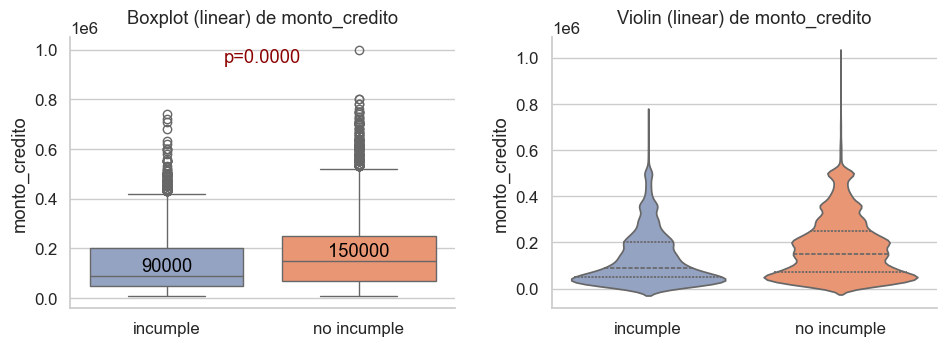



===== edad =====
                        n   mean   std  median   q25   q75            test  \
incumplimiento_txt                                                           
incumple             6636  35.73  9.69    34.0  28.0  42.0  Mann–Whitney U   
no incumple         23364  35.42  9.08    34.0  28.0  41.0  Mann–Whitney U   

                    p-value  
incumplimiento_txt           
incumple             0.3725  
no incumple          0.3725  


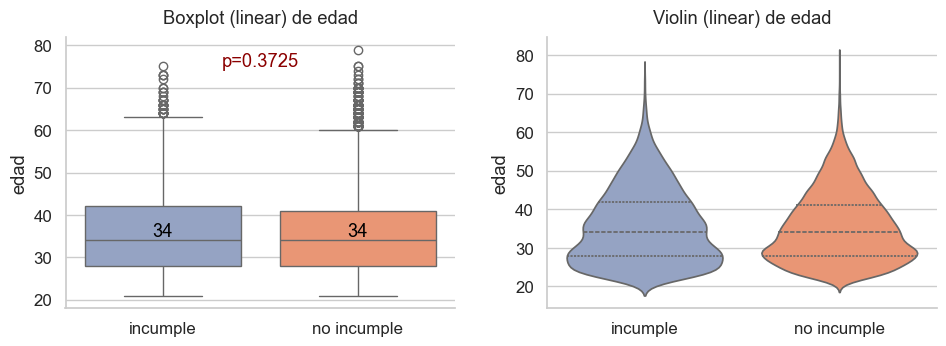



===== factura_sep2005 =====
                        n      mean       std   median      q25      q75  \
incumplimiento_txt                                                         
incumple             6636  48509.16  73782.07  20185.0  2987.75  59626.5   
no incumple         23364  51994.23  73577.61  23119.5  3677.25  69027.0   

                              test  p-value  
incumplimiento_txt                           
incumple            Mann–Whitney U      0.0  
no incumple         Mann–Whitney U      0.0  


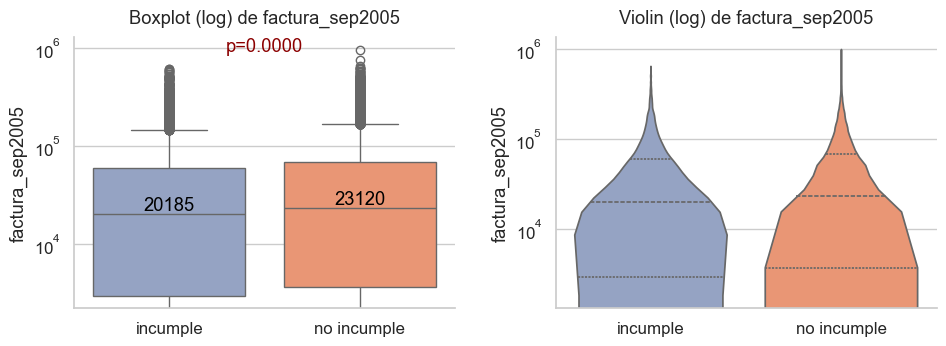



===== factura_ago2005 =====
                        n      mean       std   median     q25       q75  \
incumplimiento_txt                                                         
incumple             6636  47283.62  71651.03  20300.5  2694.0  57919.75   
no incumple         23364  49717.44  71029.95  21660.5  3055.0  65686.00   

                              test  p-value  
incumplimiento_txt                           
incumple            Mann–Whitney U   0.0071  
no incumple         Mann–Whitney U   0.0071  


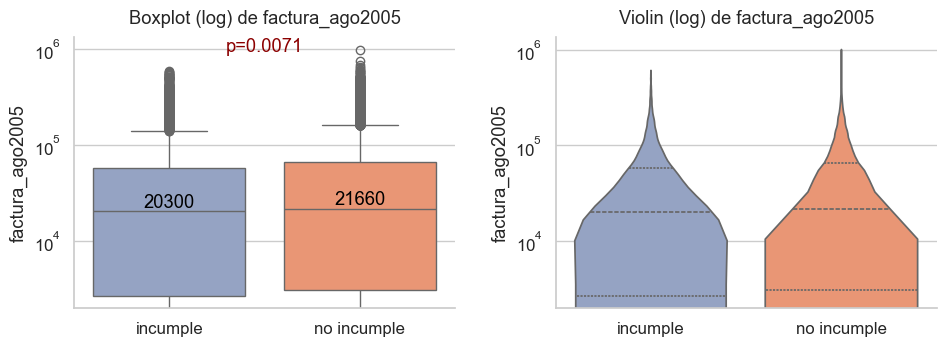



===== factura_jul2005 =====
                        n      mean       std   median      q25       q75  \
incumplimiento_txt                                                          
incumple             6636  45181.60  68516.98  19834.5  2500.00  54733.75   
no incumple         23364  47533.37  69576.66  20202.5  2769.75  61894.00   

                              test  p-value  
incumplimiento_txt                           
incumple            Mann–Whitney U   0.0282  
no incumple         Mann–Whitney U   0.0282  


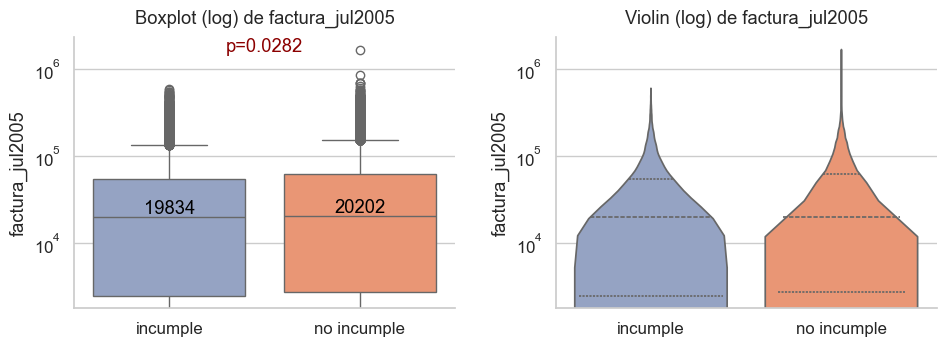



===== factura_jun2005 =====
                        n      mean       std   median     q25       q75  \
incumplimiento_txt                                                         
incumple             6636  42036.95  64351.08  19119.5  2141.5  50175.75   
no incumple         23364  43611.17  64324.80  19000.0  2360.0  55988.00   

                              test  p-value  
incumplimiento_txt                           
incumple            Mann–Whitney U   0.1478  
no incumple         Mann–Whitney U   0.1478  


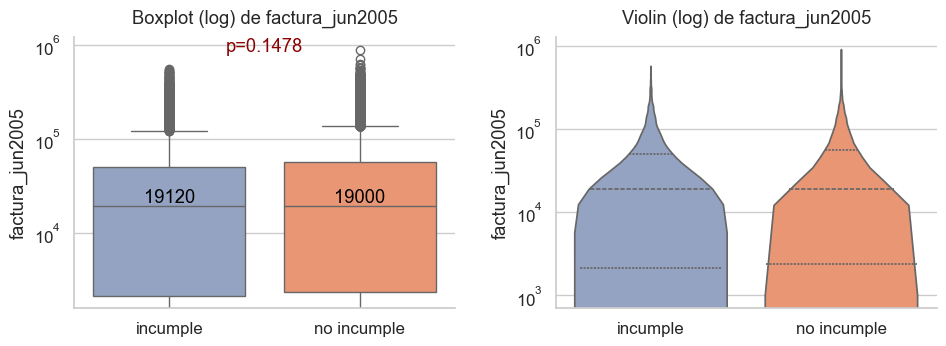



===== factura_may2005 =====
                        n      mean       std   median      q25       q75  \
incumplimiento_txt                                                          
incumple             6636  39540.19  61424.70  18478.5  1502.75  47853.00   
no incumple         23364  40530.45  60617.27  17998.0  1823.00  51135.25   

                              test  p-value  
incumplimiento_txt                           
incumple            Mann–Whitney U   0.2354  
no incumple         Mann–Whitney U   0.2354  


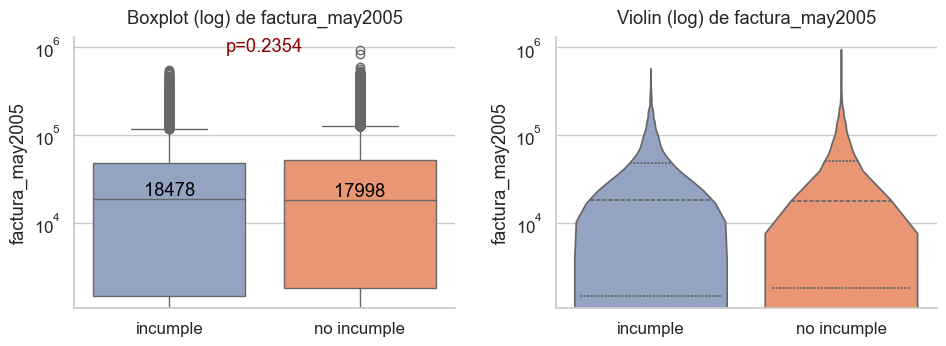



===== factura_abr2005 =====
                        n      mean       std   median     q25      q75  \
incumplimiento_txt                                                        
incumple             6636  38271.44  59579.67  18028.5  1150.0  47424.0   
no incumple         23364  39042.27  59547.02  16679.0  1265.5  49842.5   

                              test  p-value  
incumplimiento_txt                           
incumple            Mann–Whitney U   0.9895  
no incumple         Mann–Whitney U   0.9895  


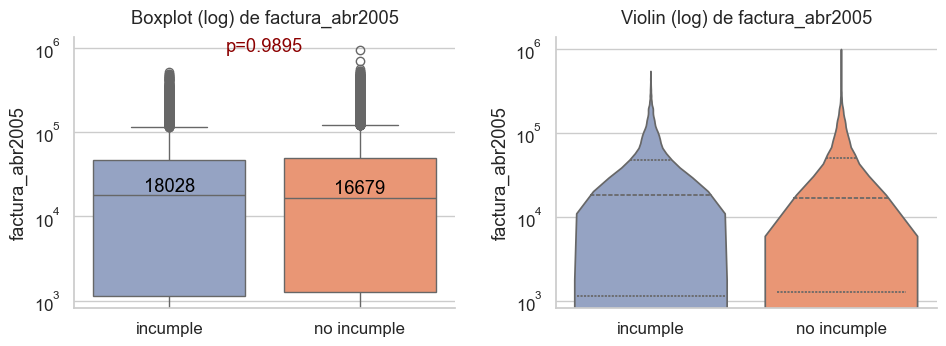



===== pagado_sep2005 =====
                        n     mean       std  median      q25      q75  \
incumplimiento_txt                                                       
incumple             6636  3397.04   9544.25  1636.0     0.00  3478.25   
no incumple         23364  6307.34  18014.51  2459.5  1163.75  5606.25   

                              test  p-value  
incumplimiento_txt                           
incumple            Mann–Whitney U      0.0  
no incumple         Mann–Whitney U      0.0  


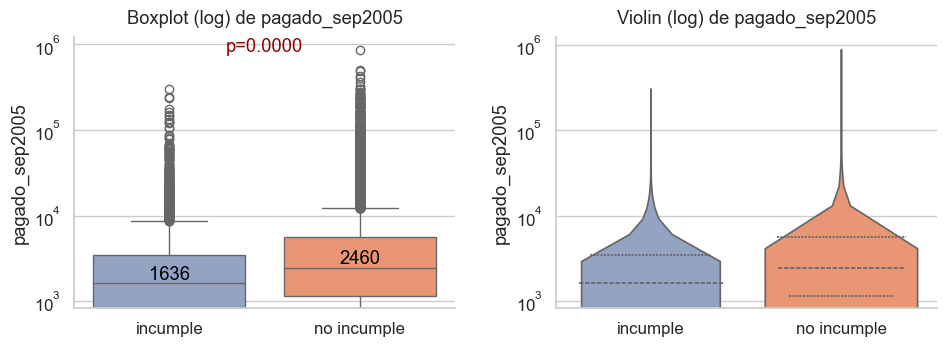



===== pagado_ago2005 =====
                        n     mean       std  median     q25      q75  \
incumplimiento_txt                                                      
incumple             6636  3388.65  11737.99  1533.5     0.0  3309.75   
no incumple         23364  6640.47  25302.26  2247.5  1005.0  5311.25   

                              test  p-value  
incumplimiento_txt                           
incumple            Mann–Whitney U      0.0  
no incumple         Mann–Whitney U      0.0  


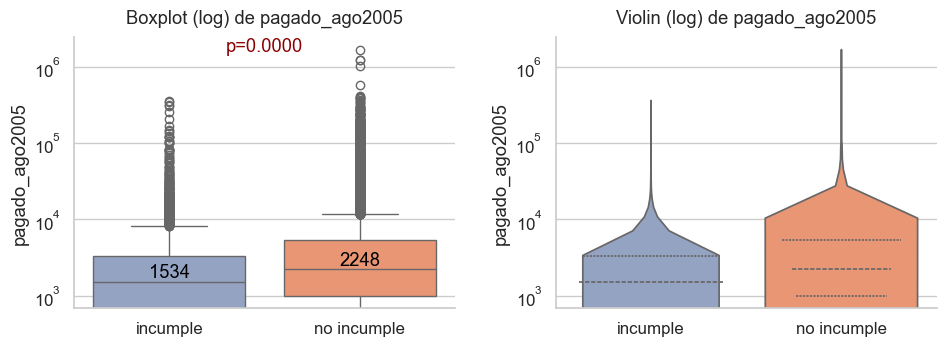



===== pagado_jul2005 =====
                        n     mean       std  median    q25     q75  \
incumplimiento_txt                                                    
incumple             6636  3367.35  12959.62  1222.0    0.0  3000.0   
no incumple         23364  5753.50  18684.26  2000.0  600.0  5000.0   

                              test  p-value  
incumplimiento_txt                           
incumple            Mann–Whitney U      0.0  
no incumple         Mann–Whitney U      0.0  


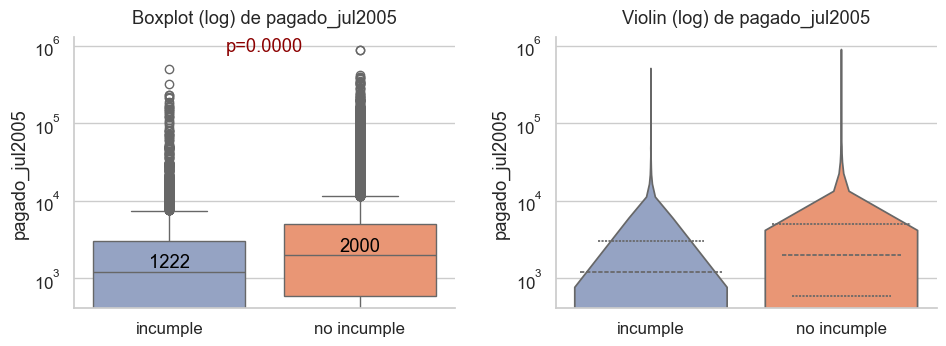



===== pagado_jun2005 =====
                        n     mean       std  median    q25      q75  \
incumplimiento_txt                                                     
incumple             6636  3155.63  11191.97  1000.0    0.0  2939.25   
no incumple         23364  5300.53  16689.78  1734.0  390.0  4602.00   

                              test  p-value  
incumplimiento_txt                           
incumple            Mann–Whitney U      0.0  
no incumple         Mann–Whitney U      0.0  


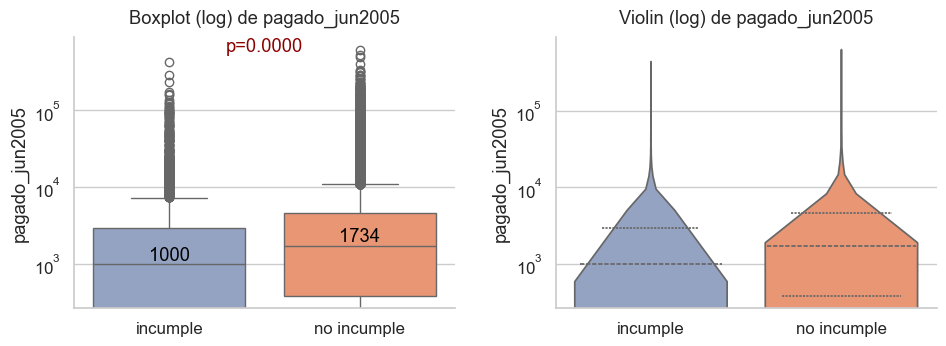



===== pagado_may2005 =====
                        n     mean       std  median    q25     q75  \
incumplimiento_txt                                                    
incumple             6636  3219.14  11944.73  1000.0    0.0  3000.0   
no incumple         23364  5248.22  16071.67  1765.0  369.0  4600.0   

                              test  p-value  
incumplimiento_txt                           
incumple            Mann–Whitney U      0.0  
no incumple         Mann–Whitney U      0.0  


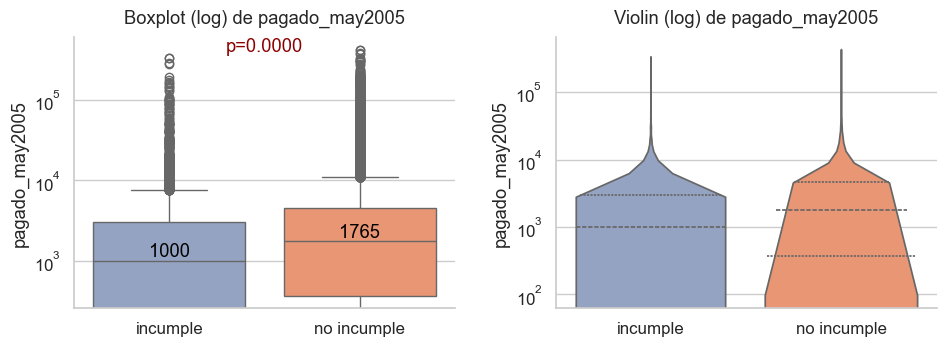



===== pagado_abr2005 =====
                        n     mean       std  median    q25     q75  \
incumplimiento_txt                                                    
incumple             6636  3441.48  13464.01  1000.0    0.0  2974.5   
no incumple         23364  5719.37  18792.95  1706.0  300.0  4545.0   

                              test  p-value  
incumplimiento_txt                           
incumple            Mann–Whitney U      0.0  
no incumple         Mann–Whitney U      0.0  


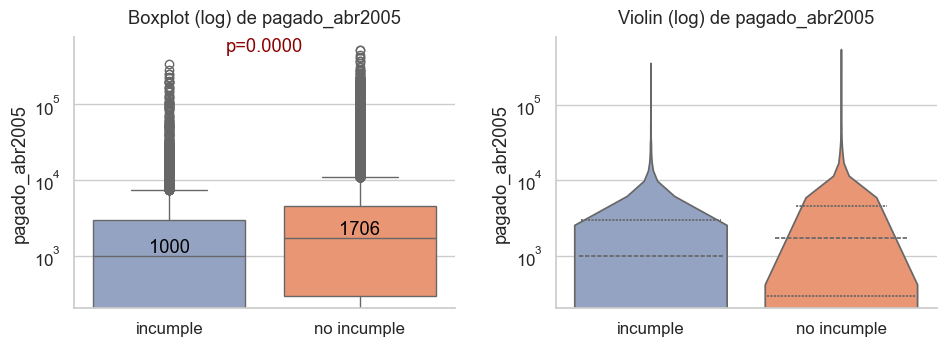



===== prom_retraso =====
                        n  mean   std  median   q25   q75            test  \
incumplimiento_txt                                                          
incumple             6636  0.30  1.15    0.33 -0.50  1.17  Mann–Whitney U   
no incumple         23364 -0.33  0.82    0.00 -0.83  0.00  Mann–Whitney U   

                    p-value  
incumplimiento_txt           
incumple                0.0  
no incumple             0.0  


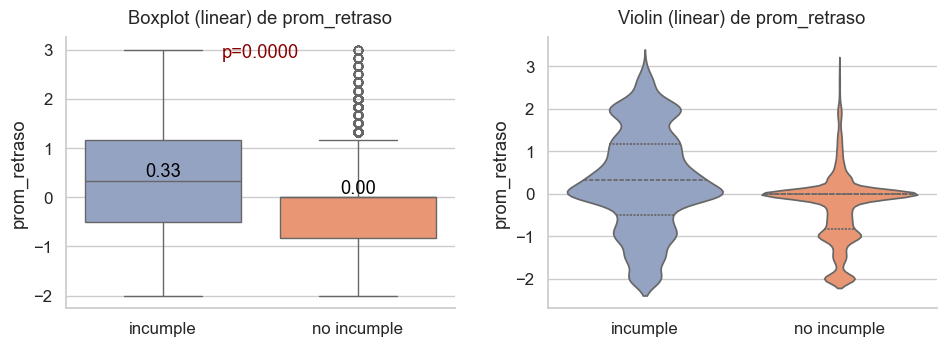



===== tend_retraso =====
                        n  mean   std  median  q25  q75            test  \
incumplimiento_txt                                                        
incumple             6636  0.17  1.22     0.0 -0.6  0.8  Mann–Whitney U   
no incumple         23364 -0.38  0.87     0.0 -1.0  0.0  Mann–Whitney U   

                    p-value  
incumplimiento_txt           
incumple                0.0  
no incumple             0.0  


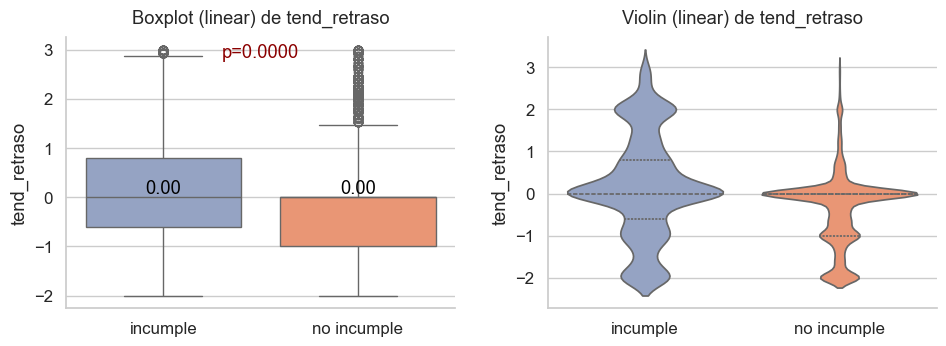

In [71]:
# Generando gráficos boxplot y violinplot para comparar grupos

# Estilo global
sns.set_theme(style="whitegrid", palette="pastel", font_scale=1.1)
plt.rcParams.update({
    'axes.spines.top':   False,
    'axes.spines.right': False,
    'figure.dpi':        100
})

# Resumen estadístico + test
def resumen_grupos(df, var, grupo_col='incumplimiento_txt'):
    g = df.groupby(grupo_col, observed=True)[var]
    stats = pd.DataFrame({
        'n':      g.size(),
        'mean':   g.mean(),
        'std':    g.std(),
        'median': g.median(),
        'q25':    g.quantile(0.25),
        'q75':    g.quantile(0.75)
    }).round(2)
    cats = stats.index.tolist()
    # normalidad
    p0 = normaltest(df[df[grupo_col]==cats[0]][var]).pvalue
    p1 = normaltest(df[df[grupo_col]==cats[1]][var]).pvalue
    # homogeneidad
    lev_p = levene(
        df[df[grupo_col]==cats[0]][var],
        df[df[grupo_col]==cats[1]][var]
    ).pvalue
    # elegir test
    if p0>0.05 and p1>0.05 and lev_p>0.05:
        stat, pval = ttest_ind(
            df[df[grupo_col]==cats[0]][var],
            df[df[grupo_col]==cats[1]][var],
            equal_var=True
        )
        test = 't-test'
    else:
        stat, pval = mannwhitneyu(
            df[df[grupo_col]==cats[0]][var],
            df[df[grupo_col]==cats[1]][var],
            alternative='two-sided'
        )
        test = 'Mann–Whitney U'
    stats['test']    = test
    stats['p-value'] = round(pval, 4)
    return stats

# Plot comparativo sin warning
def plot_comparativo(df, var, grupo_col='incumplimiento_txt'):
    stats = resumen_grupos(df, var, grupo_col)
    pval_txt = f"p={stats['p-value'].iloc[0]:.4f}"
    skew = df[var].skew()
    scale = 'log' if abs(skew)>1 else 'linear'

    fig, (ax0, ax1) = plt.subplots(1,2, figsize=(10,4))
    pal = ["#8DA0CB", "#FC8D62"]

    # Boxplot
    sns.boxplot(x=grupo_col, y=var, data=df,
                hue=grupo_col, palette=pal,
                dodge=False, ax=ax0)
    leg0 = ax0.get_legend()
    if leg0 is not None:
        leg0.remove()
    ax0.set_yscale(scale)
    ax0.set_title(f"Boxplot ({scale}) de {var}", pad=10)
    meds = df.groupby(grupo_col, observed=True)[var].median()
    for i, m in enumerate(meds):
        # si la mediana redondeada es 0, mostramos dos decimales
        if round(m) == 0:
            label = f"{m:.2f}"
        else:
            label = f"{m:.0f}"
        ax0.text(i, m, label, ha='center', va='bottom', color='black')
    ymax = df[var].max()
    ax0.text(0.5, 0.95*ymax, pval_txt, ha='center', color='darkred')

    # Violinplot
    sns.violinplot(x=grupo_col, y=var, data=df,
                   hue=grupo_col, palette=pal,
                   dodge=False, inner="quartile", ax=ax1)
    leg1 = ax1.get_legend()
    if leg1 is not None:
        leg1.remove()
    ax1.set_yscale(scale)
    ax1.set_title(f"Violin ({scale}) de {var}", pad=10)

    ax0.set_xlabel('')
    ax1.set_xlabel('')
    plt.tight_layout(pad=2)
    plt.show()

# Aplicando a todas las variables numéricas
numeric_vars = df_dccc.select_dtypes(include='number')\
                      .columns.drop(['cliente_id','incumplimiento'])

for var in numeric_vars:
    print(f"\n\n===== {var} =====")
    print(resumen_grupos(df_dccc, var))
    plot_comparativo(df_dccc, var)





In [72]:

# Copia para no tocar el original
df = df_dccc.copy()
y = df['incumplimiento'].values

# Identifica las columnas numéricas a testar
num_cols = df.select_dtypes(include='number').columns.drop(['cliente_id','incumplimiento'])

# Recorre cada variable y decide método de correlación
resultados = []
for col in num_cols:
    x = df[col]
    g0 = x[df['incumplimiento']==0]
    g1 = x[df['incumplimiento']==1]

    # Prueba de normalidad (D’Agostino) sobre una submuestra si es muy grande
    subsz = 5000
    s0 = g0.sample(subsz, random_state=42) if len(g0)>subsz else g0
    s1 = g1.sample(subsz, random_state=42) if len(g1)>subsz else g1
    p_norm0 = normaltest(s0).pvalue
    p_norm1 = normaltest(s1).pvalue

    # Homogeneidad de varianzas (Levene)
    p_levene = levene(g0, g1).pvalue

    # Decide método
    if (p_norm0>0.05 and p_norm1>0.05) and (p_levene>0.05):
        metodo = 'point-biserial (Pearson)'
        corr, p_corr = pointbiserialr(y, x)
    else:
        metodo = 'Spearman'
        corr, p_corr = spearmanr(y, x)

    resultados.append({
        'variable'        : col,
        'p_norm_grp0'     : round(p_norm0, 4),
        'p_norm_grp1'     : round(p_norm1, 4),
        'p_levene'        : round(p_levene, 4),
        'normal? (ambos)' : p_norm0>0.05 and p_norm1>0.05,
        'homoscedástica?' : p_levene>0.05,
        'método'          : metodo,
        'corr_coef'       : round(corr, 4),
        'p_valor_corr'    : round(p_corr, 4)
    })

# Montando el DataFrame final y ordénalo por fuerza de correlación
tabla = (
    pd.DataFrame(resultados)
      .set_index('variable')
      .sort_values('corr_coef', key=lambda s: s.abs(), ascending=False)
)

tabla


,p_norm_grp0,p_norm_grp1,p_levene,normal? (ambos),homoscedástica?,método,corr_coef,p_valor_corr
variable,,,,,,,,
prom_retraso,0.0,0.0,0.0000,False,False,Spearman,0.2564,0.0000
tend_retraso,0.0,0.0,0.0000,False,False,Spearman,0.2146,0.0000
monto_credito,0.0,0.0,0.0000,False,False,Spearman,-0.1696,0.0000
pagado_sep2005,0.0,0.0,0.0000,False,False,Spearman,-0.1605,0.0000
pagado_ago2005,0.0,0.0,0.0000,False,False,Spearman,-0.1510,0.0000
pagado_jul2005,0.0,0.0,0.0000,False,False,Spearman,-0.1394,0.0000
pagado_jun2005,0.0,0.0,0.0000,False,False,Spearman,-0.1280,0.0000
pagado_abr2005,0.0,0.0,0.0000,False,False,Spearman,-0.1214,0.0000
pagado_may2005,0.0,0.0,0.0000,False,False,Spearman,-0.1166,0.0000


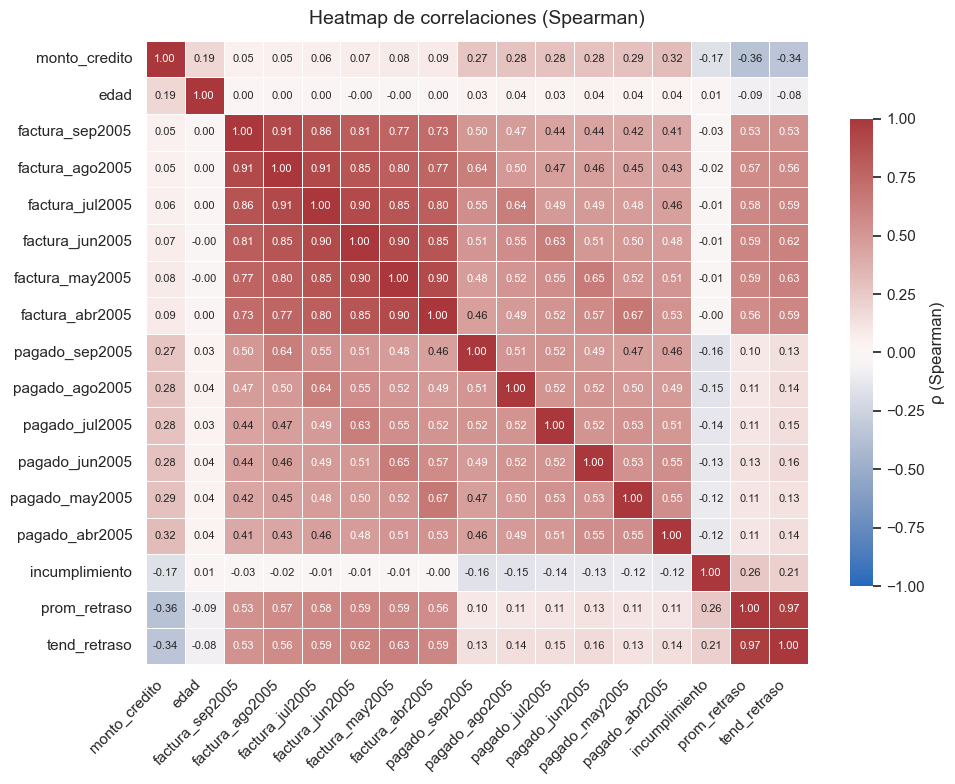

In [73]:
# Visualización de correlaciones entre variables numéricas

# Preparación de datos
df = df_dccc.copy()
id_col = 'cliente_id'
num_df = df.select_dtypes(include='number').drop(columns=[id_col])

# Cálculo de correlación de Spearman
corr = num_df.corr(method='spearman')

# Estilo general siguiendo buenas prácticas
sns.set_theme(style="whitegrid", palette="pastel", font_scale=1.0)
plt.rcParams.update({
    'axes.spines.top':    False,
    'axes.spines.right':  False,
    'figure.dpi':         100
})

# Plot
fig, ax = plt.subplots(figsize=(10, 8))

# Heatmap SIN máscara
sns.heatmap(
    corr,
    cmap='vlag',
    center=0,
    vmin=-1, vmax=1,
    annot=True,
    fmt=".2f",
    annot_kws={"size":8},
    linewidths=0.5,
    cbar_kws={
        "shrink": 0.75,
        "label": "ρ (Spearman)"
    }
)

# Ajustes finales
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
ax.set_title("Heatmap de correlaciones (Spearman)", fontsize=14, pad=12)

plt.tight_layout()
plt.show()




In [74]:
# Análisis univariante de variables numéricas con AUC

# Definir variables numéricas (excluyendo ID y target)
num_vars = [
    col for col in df_dccc
    if (
        pd.api.types.is_numeric_dtype(df_dccc[col]) 
        and col not in ['cliente_id', 'incumplimiento']
        # descartamos constantes
        and df_dccc[col].nunique(dropna=True) > 1
    )
]

# Calcular AUC univariante por variable,
# volteando si AUC < 0.5 para que siempre sea ≥0.5
auc_scores = {}
y = df_dccc['incumplimiento']
for col in num_vars:
    x = df_dccc[col].fillna(df_dccc[col].median())  # imputación sencilla
    auc = roc_auc_score(y, x)
    auc = max(auc, 1 - auc)
    auc_scores[col] = auc

# Organizar en DataFrame ordenado y redondear
auc_df = (
    pd.Series(auc_scores, name='AUC')
      .sort_values(ascending=False)
      .to_frame()
      .round(3)
)

print(auc_df)



                   AUC
prom_retraso     0.675
tend_retraso     0.646
monto_credito    0.618
pagado_sep2005   0.611
pagado_ago2005   0.605
pagado_jul2005   0.597
pagado_jun2005   0.589
pagado_abr2005   0.584
pagado_may2005   0.581
factura_sep2005  0.518
factura_ago2005  0.511
factura_jul2005  0.509
factura_jun2005  0.506
factura_may2005  0.505
edad             0.504
factura_abr2005  0.500


In [75]:
# Análisis bivariado de variables categóricas con Cramér’s V

# Selección de variables categóricas (incluye sólo 'category' u 'object')
cat_vars = (
    df_dccc
    .select_dtypes(include=['category','object'])
    .columns
    .difference(['incumplimiento', 'incumplimiento_txt'])
)

def cramers_v_corrected(ct: pd.DataFrame) -> float:
    """
    Cálculo de Cramér’s V con corrección de bias (Bergsma & Wicher):
    V_corr = sqrt( max(0, phi2 - ((k-1)(r-1))/(n-1)) / (min(k-1, r-1)) )
    """
    chi2, p, dof, expected = chi2_contingency(ct, correction=False)
    n = ct.values.sum()
    phi2 = chi2 / n
    r, k = ct.shape
    # bias correction
    phi2_corr = max(0, phi2 - ((k-1)*(r-1)) / (n-1))
    rcorr = r - ((r-1)**2) / (n-1)
    kcorr = k - ((k-1)**2) / (n-1)
    v_corr = np.sqrt(phi2_corr / min((kcorr-1), (rcorr-1)))
    return v_corr, p, expected

# Recolectar resultados
resultados = []
for col in cat_vars:
    ct = pd.crosstab(df_dccc[col], df_dccc['incumplimiento'], margins=False)
    v_corr, p_val, expected = cramers_v_corrected(ct)
    resultados.append({
        'variable': col,
        'p_valor_χ²': round(p_val, 4),
        "Cramér's V (corr)": round(v_corr, 3),

    })

# DataFrame de resumen ordenado
resumen_chi2 = (
    pd.DataFrame(resultados)
      .set_index('variable')
      .sort_values("Cramér's V (corr)", ascending=False)
)

display(resumen_chi2)



,p_valor_χ²,Cramér's V (corr)
variable,,
pago_sep2005,0.0,0.422
max_retraso,0.0,0.381
pago_ago2005,0.0,0.340
pago_jul2005,0.0,0.295
pago_jun2005,0.0,0.278
pago_may2005,0.0,0.270
pago_abr2005,0.0,0.250
nivel_educacion,0.0,0.072
genero,0.0,0.040


In [76]:
# Aplicando Feature Engineering a las variables seleccionadas

# Partir del DataFrame limpio original
df = df_dccc.copy()

# Columnas base con buen poder (AUC ≥ 0.55)
base_feats = [
    'prom_retraso',     # promedio retrasos
    'tend_retraso',     # tendencia retrasos
    'monto_credito',    # límite crédito
    'pago_sep2005',     # estado de pago último mes
    'pagado_sep2005',   # monto pagado último mes
    'max_retraso'       # retraso máximo
]

# Variables de ratio de factura (uso de línea)
fact_cols = [
    'factura_sep2005','factura_ago2005','factura_jul2005',
    'factura_jun2005','factura_may2005','factura_abr2005'
]
# Ratio factura / límite de crédito por mes
ratio_bill = df[fact_cols].div(df['monto_credito'], axis=0).clip(upper=1)
df['util_mean'] = ratio_bill.mean(axis=1)
df['util_max']  = ratio_bill.max(axis=1)
df['util_std']  = ratio_bill.std(axis=1)

# Variables de ratio de pago (pago / factura) mes a mes
pay_cols = [
    'pagado_sep2005','pagado_ago2005','pagado_jul2005',
    'pagado_jun2005','pagado_may2005','pagado_abr2005'
]
# Evitar división por cero con clip mínimo
ratio_pay = (df[pay_cols]
             .div(df[fact_cols].replace(0, np.nan), axis=0)
             .fillna(0)
             .clip(upper=2))
df['pay_ratio_mean'] = ratio_pay.mean(axis=1)
df['pay_ratio_min']  = ratio_pay.min(axis=1)
df['pay_ratio_std']  = ratio_pay.std(axis=1)
df['pay_ratio_max']  = ratio_pay.max(axis=1)

# Flag de escalación de mora: si el retraso aumentó mes a mes
# Convertimos pagos históricos originales (numéricos) a array
hist_pago = df[['pago_sep2005','pago_ago2005','pago_jul2005',
                'pago_jun2005','pago_may2005','pago_abr2005']].to_numpy()
# True si la secuencia es estrictamente creciente en alguna parte
df['delay_escalation_flag'] = np.any(np.diff(hist_pago, axis=1) > 0, axis=1).astype(int)

# Unificación de todas las nuevas variables
new_feats = [
    'util_mean','util_max','util_std',
    'pay_ratio_mean','pay_ratio_min','pay_ratio_std','pay_ratio_max',
    'delay_escalation_flag'
]

# Selección según AUC univariante (>=0.55 directa, <=0.45 invertida)
selected = []
for feat in base_feats + new_feats:
    auc = roc_auc_score(df['incumplimiento'], df[feat])
    if auc >= 0.55:
        selected.append(feat)
    elif auc <= 0.45:
        # invertimos para captar poder predictivo inverso
        df[f'{feat}_inv'] = 1 - df[feat]
        selected.append(f'{feat}_inv')

# Variables categóricas con mayor Cramér’s V
cat_sel = ['nivel_educacion', 'genero', 'estado_civil']

# Montar dataset final
final_cols = ['cliente_id','incumplimiento'] + selected + cat_sel
df_final = df[final_cols].copy()

# Opcional: codificar categorías a dummy ó ordinal
df_final = pd.get_dummies(df_final,
                         columns=cat_sel,
                         drop_first=True,
                         dtype='int8')

print("Shape final:", df_final.shape)
df_final.head(10)


Shape final: (30000, 18)


,cliente_id,incumplimiento,prom_retraso,tend_retraso,monto_credito_inv,pago_sep2005,pagado_sep2005_inv,max_retraso,util_mean,delay_escalation_flag,nivel_educacion_otros,nivel_educacion_secundaria,nivel_educacion_universidad,nivel_educacion_posgrado,genero_mujer,estado_civil_desconocido,estado_civil_otros,estado_civil_soltero
0,1,1,-0.333333,-1.400000,-19999,2,1,2,0.064200,0,0,0,1,0,1,0,0,0
1,2,1,0.500000,0.800000,-119999,-1,1,2,0.023718,1,0,0,1,0,1,0,0,1
2,3,0,0.000000,0.000000,-89999,0,-1517,0,0.188246,0,0,0,1,0,1,0,0,1
3,4,0,0.000000,0.000000,-49999,0,-1999,0,0.771113,0,0,0,1,0,1,0,0,0
4,5,0,-0.333333,-0.133333,-49999,-1,-1999,0,0.364463,1,0,0,1,0,0,0,0,0
5,6,0,0.000000,0.000000,-49999,0,-2499,0,0.696790,0,0,0,0,1,0,0,0,1
6,7,0,0.000000,0.000000,-499999,0,-54999,0,0.893981,0,0,0,0,1,0,0,0,1
7,8,0,-0.500000,-0.533333,-99999,0,-379,0,0.022477,1,0,0,1,0,1,0,0,1
8,9,0,0.333333,0.266667,-139999,0,-3328,2,0.077633,1,0,1,0,0,1,0,0,0
9,10,0,-1.666667,-1.400000,-19999,-2,1,-1,0.224325,1,0,1,0,0,0,0,0,1


In [77]:

# Definiendo el listado completo de variables candidatas
base_feats = [
    'prom_retraso',
    'tend_retraso',
    'monto_credito',
    'pago_sep2005',
    'pagado_sep2005',
    'max_retraso'
]
new_feats = [
    'util_mean',
    'util_max',
    'util_std',
    'pay_ratio_mean',
    'pay_ratio_min',
    'pay_ratio_std',
    'pay_ratio_max',
    'delay_escalation_flag'
]

all_feats = base_feats + new_feats

# Construyendo la tabla de resultados
rows = []
for feat in all_feats:
    # si hubo inversión, la columna <feat>_inv ya existe en df
    col = feat if feat in df.columns else f"{feat}_inv"
    auc = roc_auc_score(df['incumplimiento'], df[col])
    if auc >= 0.55:
        reason = 'seleccionada (AUC ≥ 0.55)'
    elif auc <= 0.45:
        reason = 'invertida (AUC ≤ 0.45)'
    else:
        reason = 'descartada (0.45 < AUC < 0.55)'
    rows.append({
        'variable': col,
        'AUC': round(auc, 3),
        'motivo': reason
    })

auc_summary = (
    pd.DataFrame(rows)
      .set_index('variable')
      .sort_values('AUC', ascending=False)
)

# Mostrando la tabla
print("### Resumen de AUC y motivo de selección/inversión/descarto")
display(auc_summary)


### Resumen de AUC y motivo de selección/inversión/descarto


,AUC,motivo
variable,,
max_retraso,0.708,seleccionada (AUC ≥ 0.55)
pago_sep2005,0.690,seleccionada (AUC ≥ 0.55)
prom_retraso,0.675,seleccionada (AUC ≥ 0.55)
tend_retraso,0.646,seleccionada (AUC ≥ 0.55)
util_mean,0.564,seleccionada (AUC ≥ 0.55)
delay_escalation_flag,0.554,seleccionada (AUC ≥ 0.55)
util_max,0.549,descartada (0.45 < AUC < 0.55)
pay_ratio_mean,0.500,descartada (0.45 < AUC < 0.55)
pay_ratio_min,0.500,descartada (0.45 < AUC < 0.55)


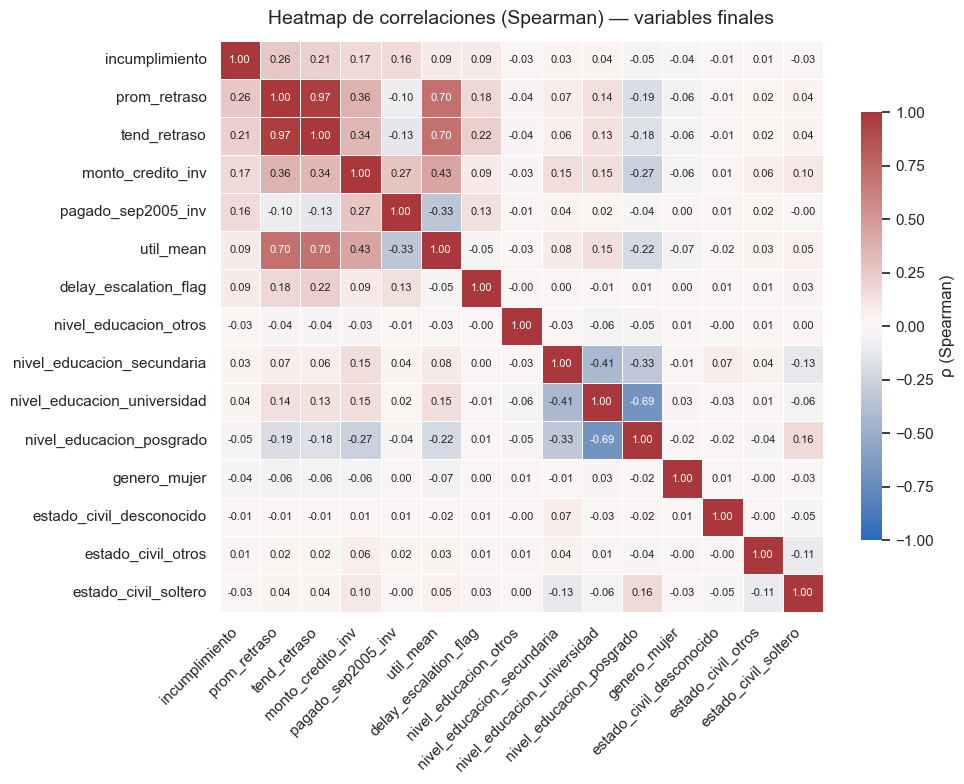


Pares con |ρ| ≥ 0.80:
        var1         var2     corr
prom_retraso tend_retraso 0.966077

Recomendaciones para multicolinealidad:
        var1         var2  corr         keep         drop                                                              motivo
prom_retraso tend_retraso 0.966 prom_retraso tend_retraso |ρ|=0.97 ≥ 0.80 → AUC(prom_retraso)=0.675 > AUC(tend_retraso)=0.646


In [78]:
# --- 1) Partir de tu df_final ya preparado ---
df = df_final.copy()

# --- 2) Seleccionar variables numéricas (excluyendo ID y target) ---
num_cols = df.select_dtypes(include='number').columns.drop(['cliente_id'])

# --- 3) Calcular matriz de correlación Spearman ---
corr = df[num_cols].corr(method='spearman')

# --- 4) Visualizar todo el heatmap sin máscara ---
sns.set_theme(style="whitegrid", palette="pastel", font_scale=1.0)
plt.rcParams.update({
    'axes.spines.top':    False,
    'axes.spines.right':  False,
    'figure.dpi':         100
})
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(
    corr, cmap='vlag', center=0, vmin=-1, vmax=1,
    annot=True, fmt=".2f", annot_kws={"size":8},
    linewidths=0.5, cbar_kws={"shrink":0.75, "label":"ρ (Spearman)"}
)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
ax.set_title("Heatmap de correlaciones (Spearman) — variables finales", fontsize=14, pad=12)
plt.tight_layout()
plt.show()

# --- 5) Extraer pares con alta correlación (|ρ| ≥ 0.8) ---
mask = np.triu(np.ones_like(corr, dtype=bool), k=1)
high_corr = (
    corr.where(mask)
        .stack()
        .reset_index()
        .rename(columns={'level_0':'var1', 'level_1':'var2', 0:'corr'})
)
high_corr = high_corr[high_corr['corr'].abs() >= 0.8]
print("\nPares con |ρ| ≥ 0.80:")
print(high_corr.to_string(index=False))

# --- 6) Calcular AUC univariante para cada variable ---
auc_dict = {feat: roc_auc_score(df['incumplimiento'], df[feat]) for feat in num_cols}

# --- 7) Elaborar recomendaciones basadas en AUC ---
recs = []
for _, row in high_corr.iterrows():
    v1, v2, c = row['var1'], row['var2'], row['corr']
    auc1, auc2 = auc_dict[v1], auc_dict[v2]
    # conservar la que tenga mayor AUC
    if auc1 >= auc2:
        keep, drop = v1, v2
    else:
        keep, drop = v2, v1
    motivo = (
        f"|ρ|={abs(c):.2f} ≥ 0.80 → "
        f"AUC({keep})={auc_dict[keep]:.3f} > AUC({drop})={auc_dict[drop]:.3f}"
    )
    recs.append({
        'var1': v1, 'var2': v2, 'corr': round(c,3),
        'keep': keep, 'drop': drop, 'motivo': motivo
    })

recommendations_df = pd.DataFrame(recs)
print("\nRecomendaciones para multicolinealidad:")
print(recommendations_df.to_string(index=False))




In [79]:
# Dataframe final
if 'tend_retraso' in df_final.columns:
    df_final = df_final.drop(columns=['tend_retraso'])

# Verifica
df_final.head(20)


,cliente_id,incumplimiento,prom_retraso,monto_credito_inv,pago_sep2005,pagado_sep2005_inv,max_retraso,util_mean,delay_escalation_flag,nivel_educacion_otros,nivel_educacion_secundaria,nivel_educacion_universidad,nivel_educacion_posgrado,genero_mujer,estado_civil_desconocido,estado_civil_otros,estado_civil_soltero
0,1,1,-0.333333,-19999,2,1,2,0.064200,0,0,0,1,0,1,0,0,0
1,2,1,0.500000,-119999,-1,1,2,0.023718,1,0,0,1,0,1,0,0,1
2,3,0,0.000000,-89999,0,-1517,0,0.188246,0,0,0,1,0,1,0,0,1
3,4,0,0.000000,-49999,0,-1999,0,0.771113,0,0,0,1,0,1,0,0,0
4,5,0,-0.333333,-49999,-1,-1999,0,0.364463,1,0,0,1,0,0,0,0,0
5,6,0,0.000000,-49999,0,-2499,0,0.696790,0,0,0,0,1,0,0,0,1
6,7,0,0.000000,-499999,0,-54999,0,0.893981,0,0,0,0,1,0,0,0,1
7,8,0,-0.500000,-99999,0,-379,0,0.022477,1,0,0,1,0,1,0,0,1
8,9,0,0.333333,-139999,0,-3328,2,0.077633,1,0,1,0,0,1,0,0,0
9,10,0,-1.666667,-19999,-2,1,-1,0.224325,1,0,1,0,0,0,0,0,1


### Decisiones de selección, creación y eliminación de variables

A continuación se resumen las variables consideradas, por qué se crearon o seleccionaron, y las razones de descartar o eliminar algunas de ellas:

---

#### 1. Variables originales seleccionadas

| Variable         | AUC   | ¿Por qué se incluyó?                                                                                   |
|------------------|-------|--------------------------------------------------------------------------------------------------------|
| **max_retraso**  | 0.708 | Máximo retraso (meses) en el historial de pagos. Mide el pico de morosidad, alto poder predictivo.     |
| **pago_sep2005** | 0.690 | Estado de pago en septiembre 2005 (ordinal). Indica el retraso más reciente, muy informativo.          |
| **prom_retraso** | 0.675 | Promedio de meses de retraso en los 6 meses previos. Resume el nivel general de morosidad.           |
| **tend_retraso** | 0.646 | Tendencia (pendiente) de retrasos mes a mes. Captura aceleración de mora.                             |
| **monto_credito**| 0.618 | Límite de crédito. Clientes con límites bajos tienden a incumplir más.                                |
| **pagado_sep2005**| 0.611| Monto efectivamente pagado en septiembre 2005. Indica capacidad de pago real reciente.                 |

> **Nota de multicolinealidad**  
> `prom_retraso` y `tend_retraso` están muy correlacionadas (ρ = 0.97). Dado que `prom_retraso` tiene un AUC ligeramente superior, **se mantiene** `prom_retraso` y **se elimina** `tend_retraso` para evitar redundancia.

---

#### 2. Variables creadas (Feature Engineering)

| Variable                  | Significado / Cálculo                                                                                                     | AUC    | Motivo de inclusión/descartar                                                                   |
|---------------------------|---------------------------------------------------------------------------------------------------------------------------|--------|------------------------------------------------------------------------------------------------|
| **util_mean**             | Uso medio de línea = promedio de (factura_mes / monto_credito) en los últimos 6 meses                                      | 0.564  | Clientes con uso alto sistemático suelen incurrir más. AUC ≥ 0.55 → **seleccionada**            |
| **delay_escalation_flag** | Indicador binario de “escalación” de retraso: 1 si el retraso (pago mensual) aumenta en alguno de los pares de meses    | 0.554  | Detecta empeoramiento reciente de comportamiento. AUC ≥ 0.55 → **seleccionada**                |

> Las demás variables de uso (`util_max`, `util_std`) y de ratios pago/factura (`pay_ratio_*`) tuvieron AUC entre 0.45–0.55 → **descartadas** por bajo poder discriminante o ruido.

---

#### 3. Variables categóricas seleccionadas

| Variable            | Cramér’s V | Motivo                                                                                   |
|---------------------|------------|------------------------------------------------------------------------------------------|
| **nivel_educacion** | 0.072      | Educación (ordinal). Clientes con educación superior tienden a incumplir menos.          |
| **genero**          | 0.040      | Género (hombre/mujer). Ligera asociación, pero aporta información demográfica.          |
| **estado_civil**    | 0.033      | Estado civil. Asociación pequeña pero útil para segmentar riesgos.                      |

> Aunque su fuerza es moderada, estas categorías se incluyen como dummies para capturar matices demográficos.

---

#### 4. Eliminaciones y transformaciones finales

- **Eliminación** de `tend_retraso` por alta multicolinealidad con `prom_retraso`.  
- **Descartar** variables con **AUC < 0.55** (salvo las ya seleccionadas).  
- **Invertir** variables con **AUC ≤ 0.45** para capturar poder predictivo inverso (por ejemplo, `pagado_sep2005_inv`, `monto_credito_inv`).

---

### Resumen de variables finales

Con este set de features conseguimos:

1. **Maximizar el recall** detectando patrones de mora históricos y recientes  
   (`max_retraso`, `prom_retraso`, `delay_escalation_flag`).  
2. **Capturar uso de línea** y comportamiento de pago  
   (`util_mean`, `pagado_sep2005`).  
3. **Incorporar información de crédito y demográfica**  
   (`monto_credito_inv`, educación, género, estado civil).  
4. **Evitar multicolinealidad, ruido y sobreajuste** al eliminar `tend_retraso` y descartar variables de bajo poder predictivo.


[LightGBM] [Info] Number of positive: 4645, number of negative: 16355
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000310 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 600
[LightGBM] [Info] Number of data points in the train set: 21000, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.221190 -> initscore=-1.258742
[LightGBM] [Info] Start training from score -1.258742
          accuracy  precision  recall     f1  roc_auc
model                                                
CatBoost     0.817      0.659   0.362  0.467    0.774
LightGBM     0.816      0.656   0.354  0.460    0.772
TabNet       0.815      0.649   0.353  0.457    0.765
XGBoost      0.810      0.625   0.357  0.455    0.756
BalRF        0.758      0.462   0.579  0.514    0.754
MLP          0.785      0.623   0.076  0.136    0.636


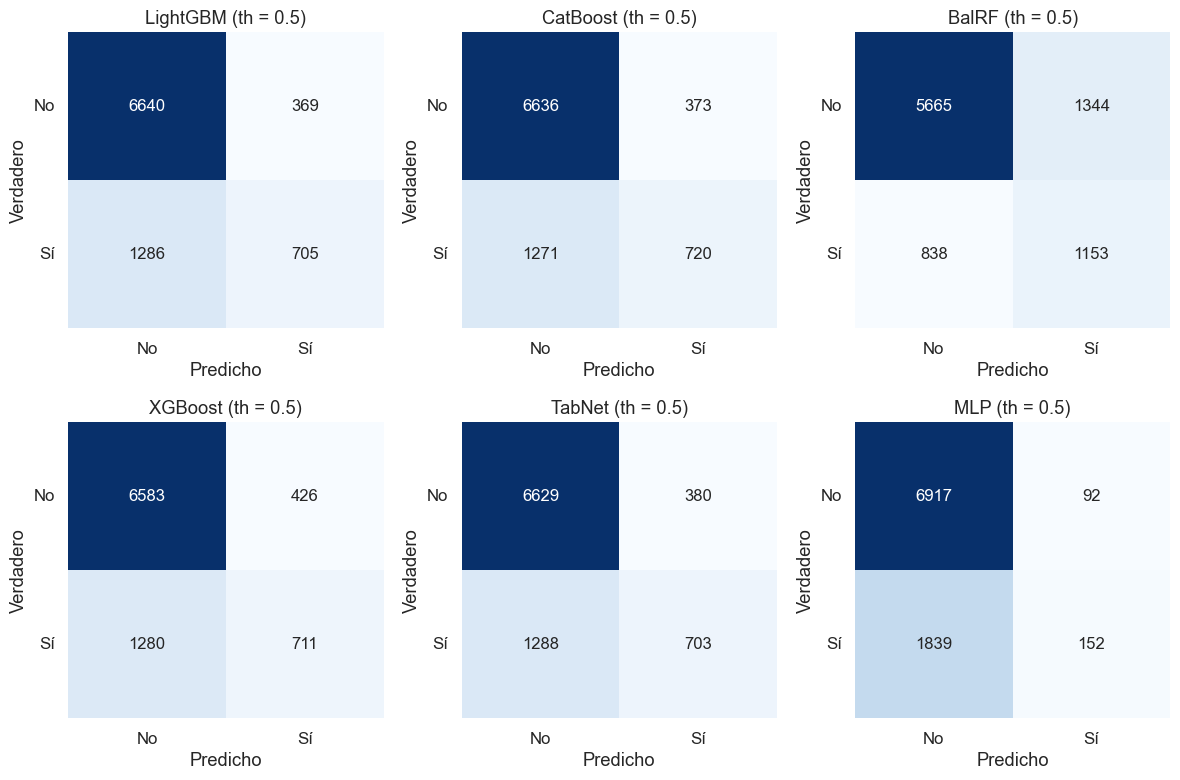

In [94]:
# Aplicando modelos de clasificación en baseline

# Ocultar todas las advertencias
warnings.filterwarnings('ignore')


# Prepararando los datos

df  = df_final.copy()
X   = df.drop(columns=['cliente_id', 'incumplimiento'])
y   = df['incumplimiento']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, stratify=y, random_state=42
)


# Diccionario de modelos

models = {
    'LightGBM': LGBMClassifier(random_state=42),
    'CatBoost': CatBoostClassifier(verbose=0, random_state=42),
    'BalRF':    BalancedRandomForestClassifier(random_state=42),
    'XGBoost':  XGBClassifier(
                    use_label_encoder=False,
                    eval_metric='logloss',
                    random_state=42),
    'TabNet':   TabNetClassifier(verbose=0, seed=42),
    'MLP':      MLPClassifier(random_state=42)
}


# Entrenamiento, predicción y métricas

results, conf_matrices = [], {}

for name, clf in models.items():
    # TabNet requiere arrays; los demás aceptan DataFrame
    Xtr, Xte = X_train.values, X_test.values
    
    # Entrenar
    clf.fit(Xtr, y_train)
    
    # Probabilidades y predicciones a th = 0.5
    y_proba = clf.predict_proba(Xte)[:, 1]
    y_pred  = (y_proba >= 0.5).astype(int)

    # Métricas
    results.append({
        'model':      name,
        'accuracy':   accuracy_score(y_test, y_pred),
        'precision':  precision_score(y_test, y_pred, zero_division=0),
        'recall':     recall_score(y_test, y_pred),
        'f1':         f1_score(y_test, y_pred),
        'roc_auc':    roc_auc_score(y_test, y_proba)
    })
    conf_matrices[name] = confusion_matrix(y_test, y_pred)


# Tabla de resultados

res_df = (
    pd.DataFrame(results)
      .set_index('model')
      .round(3)
      .sort_values('roc_auc', ascending=False)
)
print(res_df)


# Matrices de confusión

sns.set_theme(style="whitegrid", font_scale=1.1)
n_models = len(conf_matrices)
cols     = 3
rows     = int(np.ceil(n_models / cols))
fig, axes = plt.subplots(rows, cols, figsize=(cols * 4, rows * 4))
axes = axes.flatten()

for ax, (name, cm) in zip(axes, conf_matrices.items()):
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                cbar=False, ax=ax, annot_kws={'size': 12})
    ax.set_title(f"{name} (th = 0.5)")
    ax.set_xlabel('Predicho')
    ax.set_ylabel('Verdadero')
    ax.set_xticklabels(['No', 'Sí'])
    ax.set_yticklabels(['No', 'Sí'], rotation=0)

# Desactivar ejes vacíos
for ax in axes[n_models:]:
    ax.axis('off')

plt.tight_layout()
plt.show()
